In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import chi2_contingency
from IPython.display import display, HTML
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTENC

In [3]:
os.makedirs("/home/onyxia/work/Federated_Learning_Milliman/images", exist_ok=True)

In [4]:

FEATURES = ["Power", "DriverAge", "Density", "Sex", "Fuel_type"]
CATEGORICAL_FEATURES_IDX = [3, 4]  # 'Sex', 'Fuel_type'
TARGET = "Sinistre"
EXPOSURE_COL = "Exposure"
GROUP_COL = "Country"
TEST_SIZE = 0.4
SAMPLING_STRATEGY = 0.43  # pour atteindre environ 70/30
RANDOM_STATE = 42

# ============================
# Fonction : Chargement + augmentation
# ============================
def load_and_augment(csv_path, country_name):
    df = pd.read_csv(csv_path).dropna()
    X = df[FEATURES].values
    y = df[TARGET].values
    exposure = df[EXPOSURE_COL].values

    # Split train/test
    X_train, X_test, y_train, y_test, exposure_train, _ = train_test_split(
        X, y, exposure, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )

    # SMOTENC sur le train uniquement
    smote_nc = SMOTENC(categorical_features=CATEGORICAL_FEATURES_IDX, 
                       sampling_strategy=SAMPLING_STRATEGY,
                       random_state=RANDOM_STATE)
    X_train_aug, y_train_aug = smote_nc.fit_resample(X_train, y_train)

    # Ajuster l'exposition pour les nouvelles instances
    n_augmented = len(X_train_aug) - len(X_train)
    exposure_aug = np.concatenate([
        exposure_train,
        np.random.choice(exposure_train[y_train == 1], size=n_augmented, replace=True)
    ])

    # Création du DataFrame pour analyse
    df_train_aug = pd.DataFrame(X_train_aug, columns=FEATURES)
    df_train_aug["Sinistre"] = y_train_aug
    df_train_aug["Exposure"] = exposure_aug
    df_train_aug[GROUP_COL] = country_name

    return df_train_aug

# ============================
# MAIN SCRIPT
# ============================
if __name__ == "__main__":
    # Exemple pour freMTPL
    df_aug_fre = load_and_augment("/home/onyxia/work/Federated_Learning_Milliman/data/french_data.csv", "France")
    df_aug_be = load_and_augment("/home/onyxia/work/Federated_Learning_Milliman/data/belgium_data.csv", "Belgique")
    df_aug_eu = load_and_augment("/home/onyxia/work/Federated_Learning_Milliman/data/french_data.csv", "Europe")



In [5]:
# Étape 1 : Ajouter une colonne d'identification
df_aug_fre['Country'] = 'French'
df_aug_be['Country'] = 'Belgium'
df_aug_eu['Country'] = 'European'

In [6]:
data_aug = pd.concat([df_aug_fre, df_aug_eu, df_aug_be], ignore_index=True)
data_aug


,Power,DriverAge,Density,Sex,Fuel_type,Sinistre,Exposure,Country
0,0.000000,0.573171,0.016927,0.0,1.0,0,0.230000,French
1,0.008621,0.426829,0.010408,0.0,1.0,0,1.000000,French
2,0.051724,0.268293,0.007334,0.0,0.0,0,0.080000,French
3,0.000000,0.719512,0.001778,0.0,0.0,1,0.970000,French
4,0.008621,0.292683,0.000963,1.0,1.0,0,1.000000,French
...,...,...,...,...,...,...,...,...
1909251,0.203733,0.381215,0.162643,0.0,0.0,1,1.000000,Belgium
1909252,0.070494,0.194805,0.031338,0.0,0.0,1,0.860274,Belgium
1909253,0.354347,0.200482,0.032977,1.0,0.0,1,1.000000,Belgium
1909254,0.160280,0.558442,0.002861,1.0,0.0,1,1.000000,Belgium


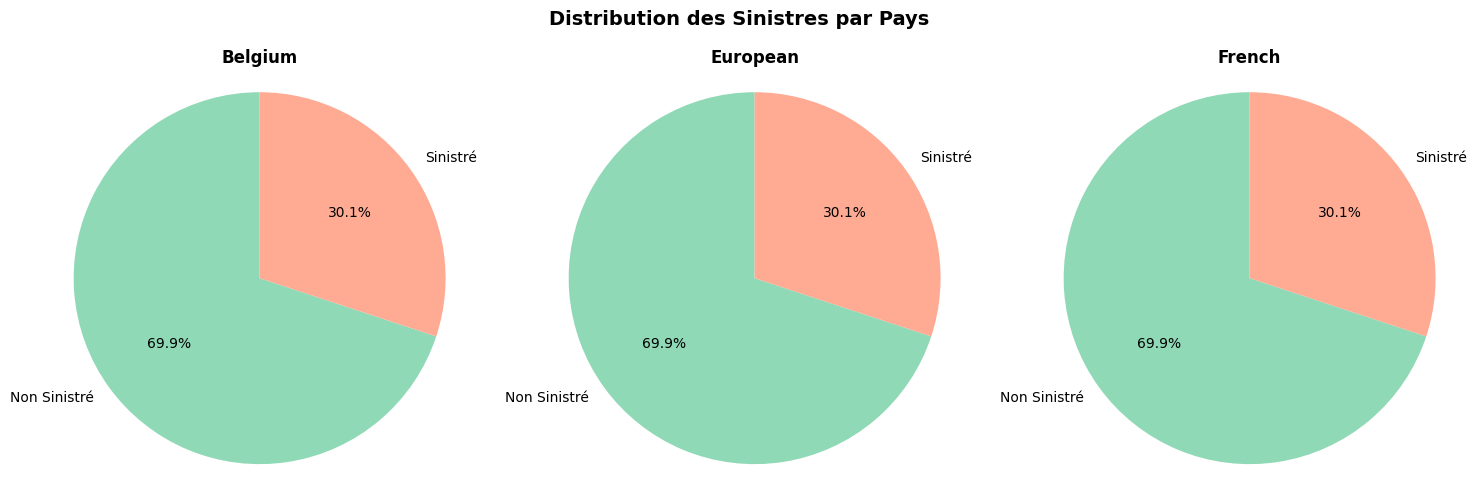

In [7]:
df_prop = data_aug.groupby('Country')['Sinistre'].value_counts(normalize=True).unstack().fillna(0)
df_prop.columns = ['Non Sinistré', 'Sinistré']  # Renommage des colonnes pour clarté

# Création de la figure avec 3 pie charts
fig, axes = plt.subplots(1, len(df_prop), figsize=(15, 5))

colors = ['#8fd9b6', '#ffab94']

for i, (country, row) in enumerate(df_prop.iterrows()):
    ax = axes[i]
    ax.pie(row, labels=row.index, autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(f"{country}", fontsize=12, weight='bold')
    ax.axis('equal')  # Pour que le pie chart soit un cercle

fig.suptitle("Distribution des Sinistres par Pays", fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig(f"images/piechart_Sinistre.png")
plt.show()

# Distribution de chaque variable

In [8]:
def afficher_repartition_sinistres(data, name, colonne="Sinistre", palette=["cyan", "red"], figsize=(6, 4)):
    class_distribution = data[colonne].value_counts(normalize=True) * 100

    plt.figure(figsize=figsize)
    sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=palette)
    plt.xlabel(f"Classe {colonne} (0 = Pas de sinistre, 1 = Sinistre)")
    plt.ylabel("Proportion (%)")
    plt.title("Répartition des sinistres dans le dataset")
    plt.xticks([0, 1], ["Pas de sinistre", "Sinistre"])
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig(f"images/distribution_{colonne}_{name}.png")
    plt.show()


In [9]:
# Style plus joli pour les plots
sns.set(style='whitegrid')


In [10]:
# Exemple de couleurs pour chaque variable
hist_colors = ['skyblue', 'lightgreen', 'salmon', 'plum']
kde_colors = ['blue', 'green', 'red', 'purple']

numerical_vars = ['Exposure', 'Power', 'DriverAge', 'Density']

# for i, var in enumerate(numerical_vars):
#     plt.figure(figsize=(8, 4))
    
#     # Histogramme sans la courbe KDE
#     sns.histplot(data[var], bins=30, color=hist_colors[i], stat="density", edgecolor="black", kde=False)
    
#     # Ajout de la courbe KDE avec une couleur différente
#     sns.kdeplot(data[var], color=kde_colors[i], linewidth=2)
    
#     plt.title(f'Distribution de {var}')
#     plt.xlabel(var)
#     plt.ylabel("Densité")
#     plt.tight_layout()
#     plt.show()


In [11]:
categorical_vars = ['Fuel_type', 'Sex', 'Country']

# Quelques palettes différentes de Seaborn
palettes = ['Set2', 'pastel', 'husl', 'muted']

# for i, var in enumerate(categorical_vars):
#     plt.figure(figsize=(6, 4))
#     sns.countplot(x=var, data=data, palette=palettes[i])
#     plt.title(f'Répartition de {var}')
#     plt.xlabel(var)
#     plt.ylabel("Nombre")
#     plt.tight_layout()
#     plt.show()


In [12]:
def analyse_variable_numerique(df, var_num, name, cible='Sinistre'):
    print(f"## Analyse de la variable numérique : {var_num}\n")
    
    # Statistiques descriptives
    display(df[[var_num]].describe())

    # Boxplot par classe
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')
    plt.title(f'{var_num} selon {cible}')
    plt.grid(True)
    plt.savefig(f"images/boxplot_{var_num}_{name}.png")
    plt.show()

    # Distribution KDE
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x=var_num, hue=cible, common_norm=False, fill=True)
    plt.title(f'Distribution de {var_num} selon {cible}')
    plt.savefig(f"images/distribution_{var_num}_{name}.png")
    plt.grid(True)
    plt.show()

        # Test de Kolmogorov-Smirnov
    groupe_0 = df[df[cible] == 0][var_num].dropna()
    groupe_1 = df[df[cible] == 1][var_num].dropna()
    ks_stat, p_value = ks_2samp(groupe_0, groupe_1)

    print("\n" + "="*60)
    print(f"🧪 Test de Kolmogorov-Smirnov sur la variable '{var_num}'")
    print("-" * 60)
    print(f"📈 Statistique KS : {ks_stat:.4f}")
    print(f"📊 Valeur p       : {p_value:.4e}")

    # Interprétation statistique
    if p_value < 0.05:
        print("✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)")
    else:
        print("❌ Résultat : Aucune différence significative détectée (p ≥ 0.05)")

    # Interprétation de l'intensité de la différence
    if ks_stat < 0.1:
        intensite = "⚪️ Très faible différence"
    elif ks_stat < 0.2:
        intensite = "🟢 Faible différence"
    elif ks_stat < 0.3:
        intensite = "🟠 Différence modérée"
    else:
        intensite = "🔴 Forte différence"

    print(f"📌 Intensité de l'écart : {intensite}")

    # Différence de médiane
    med_0 = groupe_0.median()
    med_1 = groupe_1.median()
    diff_medianes = abs(med_0 - med_1)

    print("-" * 60)
    print(f"📉 Médiane (classe 0) : {med_0:.2f}")
    print(f"📈 Médiane (classe 1) : {med_1:.2f}")
    print(f"➡️  Différence absolue de médiane : {diff_medianes:.2f}")
    print("="*60 + "\n")



In [13]:
def analyse_variable_categorielle(df, var_cat, name, cible='Sinistre'):
    print(f"## Analyse de la variable catégorielle : {var_cat}\n")
    
    # Calcul du taux de sinistre + nombre d'observations + sinistres
    stats = df.groupby(var_cat).agg(
        Effectif=(cible, 'count'),
        Nombre_sinistres=(cible, 'sum'),
        Taux_de_sinistre=(cible, 'mean')
    ).sort_values(by='Taux_de_sinistre', ascending=False).reset_index()

    # Affichage stylisé
    display(stats.style
            .format({'Taux_de_sinistre': '{:.2%}'})
            .background_gradient(cmap='Reds', subset=['Taux_de_sinistre'])
            .set_caption(f"Taux de sinistre par '{var_cat}'"))

    # Diagramme en barres verticales
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(data=df, x=var_cat, hue=cible, palette='Set2')
    plt.title(f'Distribution de {var_cat} selon {cible}')
    plt.xticks(rotation=90)  # Modalités affichées verticalement
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f"images/diagramme_{var_cat}_{name}.png")
    plt.show()


# Corrélation 

In [14]:
def afficher_correlation(data, variables, name, figsize=(7, 5), cmap="coolwarm"):
    corr_matrix = data[variables].corr()

    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, cmap=cmap, fmt=".2f")
    plt.title("Corrélations entre variables numériques")
    plt.tight_layout()
    plt.savefig(f"images/corrplot_{name}.png")
    plt.show()


In [15]:
def analyze_categorical_correlation(data, cat_vars=['Fuel_type','Sinistre', 'Sex'], 
                                   alpha=0.05, figsize=(10, 8)):
   
    # Préparation des données
    cat_df = data[cat_vars].copy()
    for col in cat_df.select_dtypes(include='bool'):
        cat_df[col] = cat_df[col].astype(str)
    
    # Calcul des résultats
    results = []
    for i, var1 in enumerate(cat_vars[:-1]):
        for var2 in cat_vars[i+1:]:
            contingency_table = pd.crosstab(cat_df[var1], cat_df[var2])
            chi2, p, dof, _ = chi2_contingency(contingency_table)
            
            # Calcul du Cramer's V
            n = contingency_table.sum().sum()
            cramer_v = np.sqrt(chi2 / (n * min(contingency_table.shape[0]-1, contingency_table.shape[1]-1)))
            
            # Interprétation
            strength = "Très forte" if cramer_v >= 0.5 else \
                     "Forte" if cramer_v >= 0.3 else \
                     "Modérée" if cramer_v >= 0.1 else "Faible"
            
            results.append({
                'Paire de variables': f"{var1} - {var2}",
                'Cramer\'s V': cramer_v,
                'Force de la corrélation': strength,
                'p-value': p,
                'Significatif': p < alpha
            })
    
    # Création du DataFrame de résultats
    results_df = pd.DataFrame(results)
    
    # Style pour la visualisation
    def color_strength(val):
        color = 'white'
        if val == "Très forte": color = '#FF0000'  # Rouge
        elif val == "Forte": color = '#FF6666'     # Rouge clair
        elif val == "Modérée": color = '#FFCCCC'   # Rouge très clair
        return f'background-color: {color}'
    
    def color_pvalue(val):
        color = 'limegreen' if val < alpha else 'lightcoral'
        return f'color: {color}; font-weight: bold'
    
    # Application du style
    styled_df = results_df.style \
        .applymap(color_pvalue, subset=['p-value']) \
        .applymap(lambda x: 'background-color: limegreen' if x else 'background-color: lightcoral', 
                 subset=['Significatif']) \
        .applymap(color_strength, subset=['Force de la corrélation']) \
        .format({
            'Cramer\'s V': "{:.3f}",
            'p-value': "{:.4f}"
        }) \
        .set_caption("Résultats des tests de corrélation entre variables catégorielles") \
        .set_properties(**{
            'text-align': 'center',
            'font-size': '12pt',
            'border': '1px solid black'
        })
    
    # Affichage dans Jupyter
    display(styled_df)
    return results_df


In [16]:
#STATS DE LA BASE CONCATÉNER 
# Liste des variables
vars_num = ['Exposure', 'Power', 'DriverAge', 'Density']
vars_cat = ['Fuel_type', 'Sex']


# afficher_repartition_sinistres(data)
# # Analyse automatique
# for var in vars_num:
#     analyse_variable_numerique(data, var)

# for var in vars_cat:
#     analyse_variable_categorielle(data, var)

# #Corrélation 
# afficher_correlation(data, vars_num)
# results = analyze_categorical_correlation(data)

# Base française 

/tmp/ipykernel_248340/797443313.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=palette)


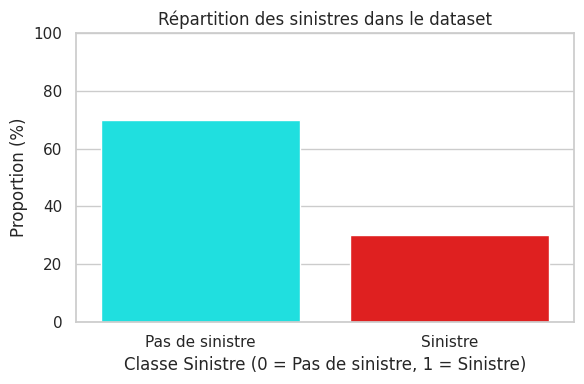

## Analyse de la variable numérique : Exposure



,Exposure
count,892451.000000
mean,0.572473
std,0.361947
min,0.002732
25%,0.230000
50%,0.560000
75%,1.000000
max,1.000000


/tmp/ipykernel_248340/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


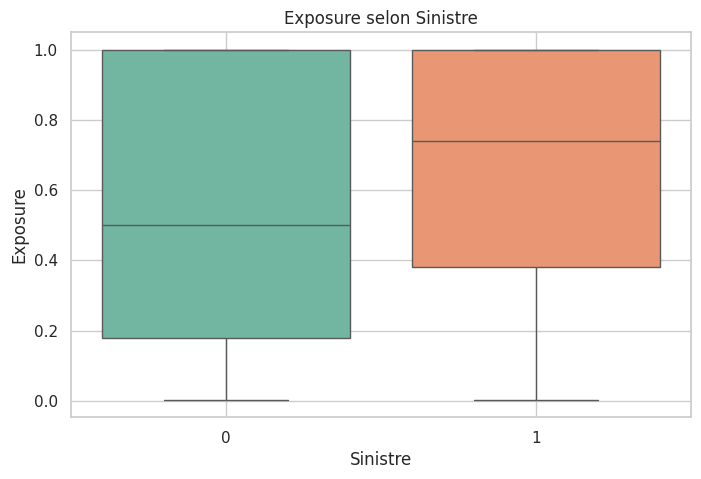

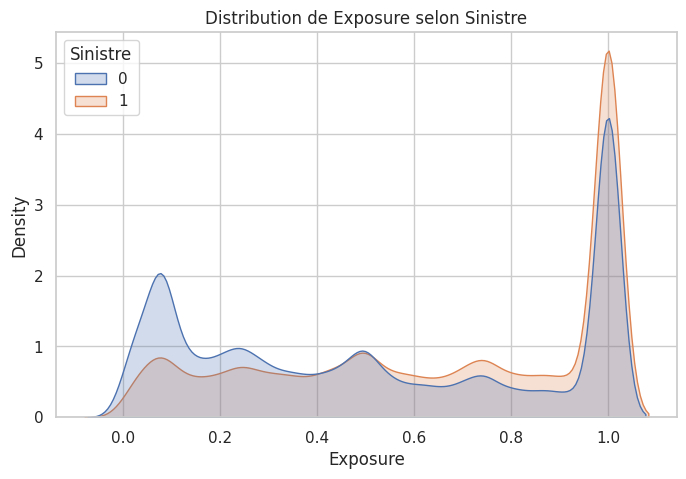


🧪 Test de Kolmogorov-Smirnov sur la variable 'Exposure'
------------------------------------------------------------
📈 Statistique KS : 0.1634
📊 Valeur p       : 0.0000e+00
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : 🟢 Faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.50
📈 Médiane (classe 1) : 0.74
➡️  Différence absolue de médiane : 0.24

## Analyse de la variable numérique : Power



,Power
count,892451.000000
mean,0.116908
std,0.151295
min,0.000000
25%,0.017241
50%,0.025862
75%,0.224138
max,1.000000


/tmp/ipykernel_248340/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


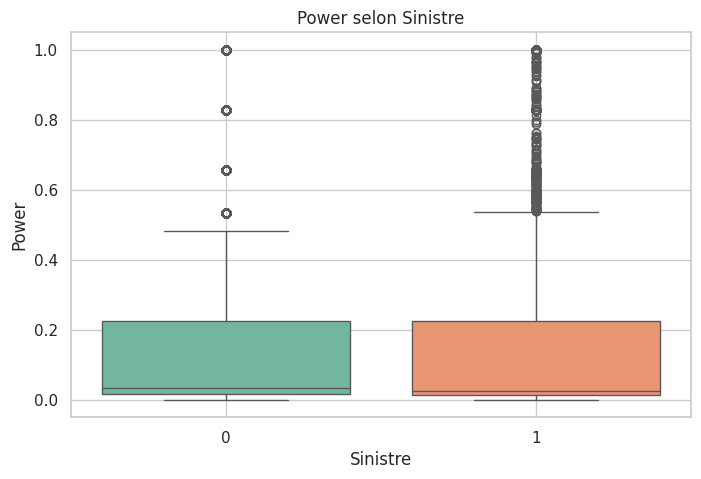

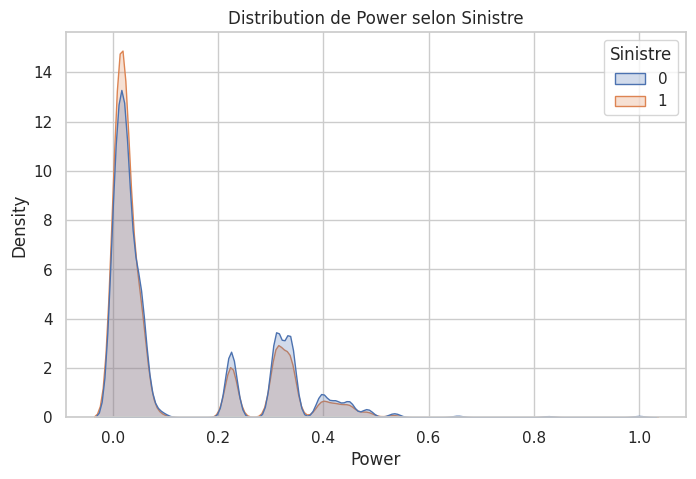


🧪 Test de Kolmogorov-Smirnov sur la variable 'Power'
------------------------------------------------------------
📈 Statistique KS : 0.0835
📊 Valeur p       : 0.0000e+00
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.03
📈 Médiane (classe 1) : 0.03
➡️  Différence absolue de médiane : 0.01

## Analyse de la variable numérique : DriverAge



,DriverAge
count,892451.000000
mean,0.335682
std,0.175353
min,0.000000
25%,0.195122
50%,0.327242
75%,0.451220
max,1.000000


/tmp/ipykernel_248340/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


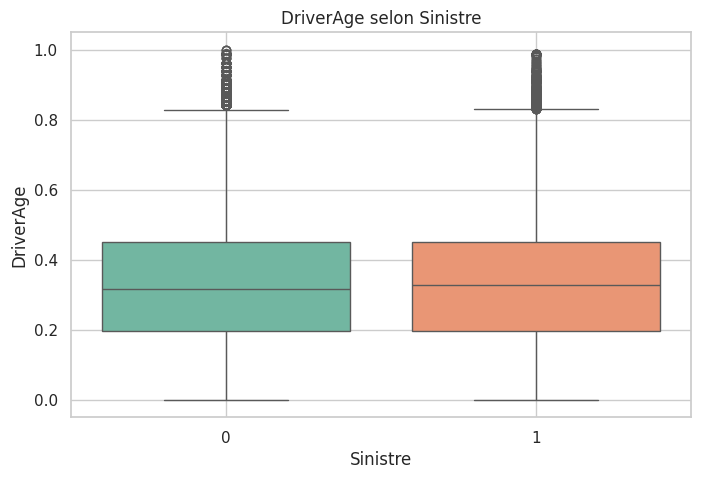

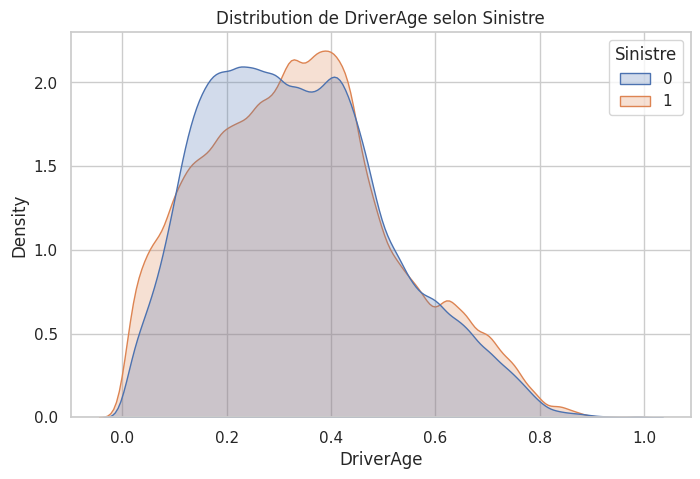


🧪 Test de Kolmogorov-Smirnov sur la variable 'DriverAge'
------------------------------------------------------------
📈 Statistique KS : 0.0318
📊 Valeur p       : 5.4912e-165
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.32
📈 Médiane (classe 1) : 0.33
➡️  Différence absolue de médiane : 0.01

## Analyse de la variable numérique : Density



,Density
count,892451.000000
mean,0.069785
std,0.159811
min,0.000000
25%,0.003148
50%,0.013223
75%,0.059224
max,1.000000


/tmp/ipykernel_248340/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


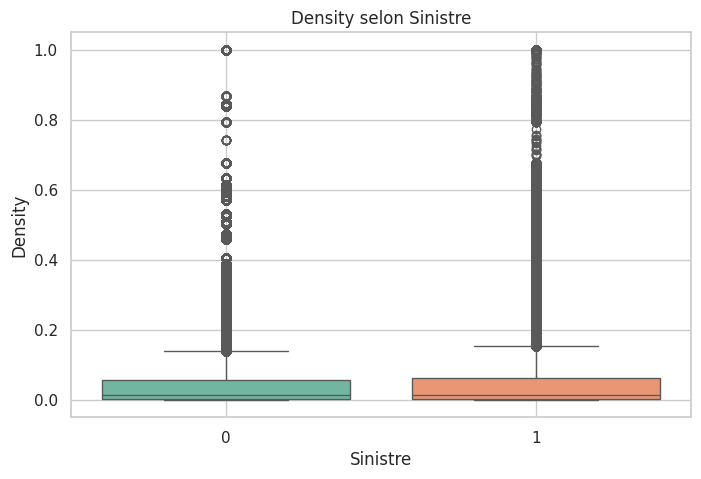

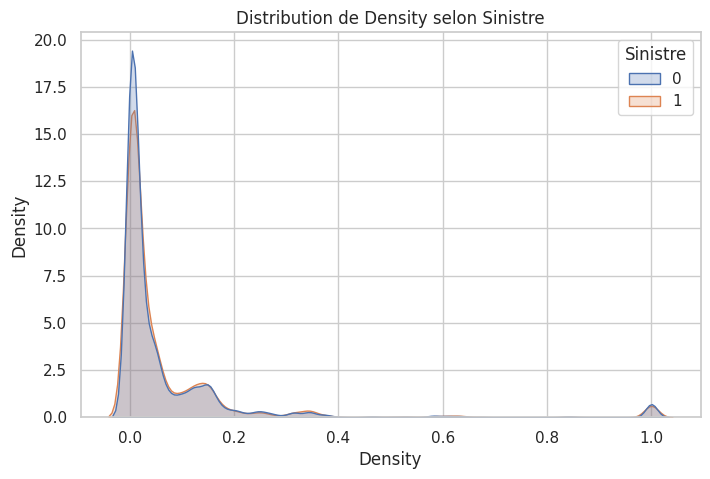


🧪 Test de Kolmogorov-Smirnov sur la variable 'Density'
------------------------------------------------------------
📈 Statistique KS : 0.0402
📊 Valeur p       : 1.8245e-264
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.01
📈 Médiane (classe 1) : 0.01
➡️  Différence absolue de médiane : 0.00

## Analyse de la variable catégorielle : Fuel_type



,Fuel_type,Effectif,Nombre_sinistres,Taux_de_sinistre
0,0.000000,456729,140447,30.75%
1,1.000000,435722,127912,29.36%


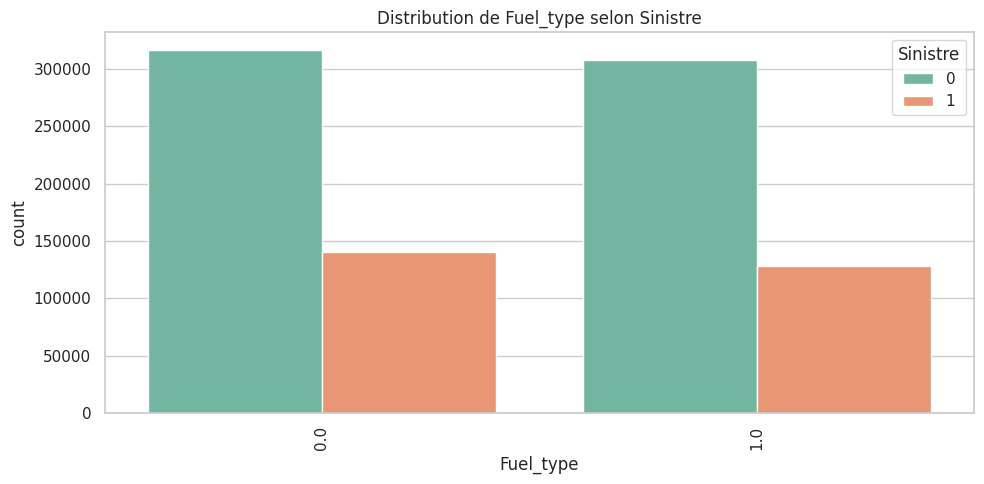

## Analyse de la variable catégorielle : Sex



,Sex,Effectif,Nombre_sinistres,Taux_de_sinistre
0,1.000000,489600,177598,36.27%
1,0.000000,402851,90761,22.53%


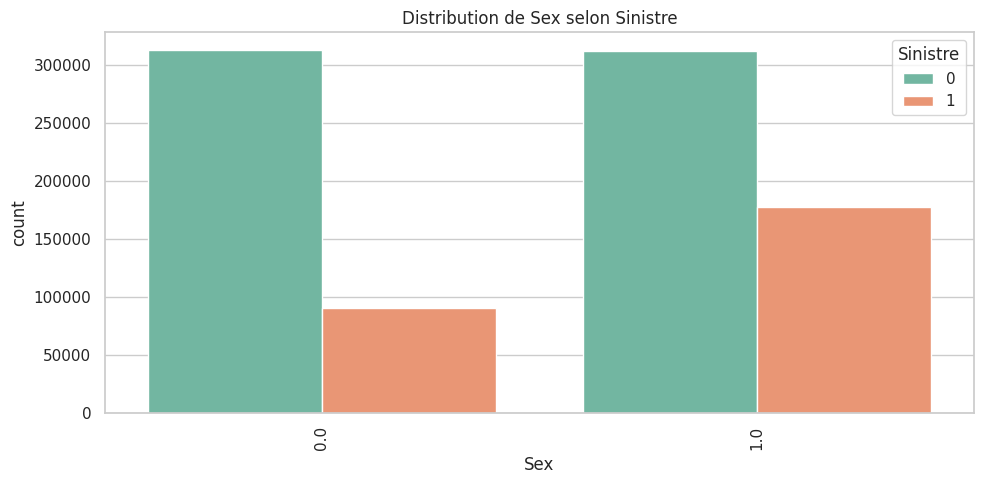

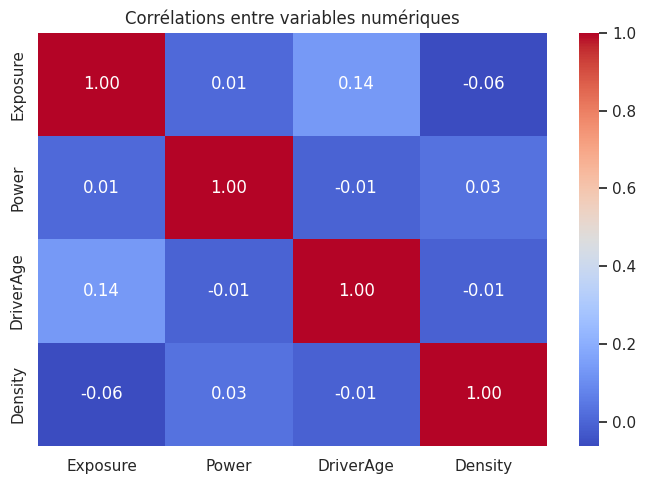

/tmp/ipykernel_248340/2745208832.py:50: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_pvalue, subset=['p-value']) \
/tmp/ipykernel_248340/2745208832.py:51: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'background-color: limegreen' if x else 'background-color: lightcoral',
/tmp/ipykernel_248340/2745208832.py:53: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_strength, subset=['Force de la corrélation']) \


,Paire de variables,Cramer's V,Force de la corrélation,p-value,Significatif
0,Fuel_type - Sinistre,0.015,Faible,0.0000,True
1,Fuel_type - Sex,0.005,Faible,0.0000,True
2,Sinistre - Sex,0.149,Modérée,0.0000,True


In [17]:
# Liste des variables
vars_num = ['Exposure', 'Power', 'DriverAge', 'Density']
vars_cat = ['Fuel_type', 'Sex']


afficher_repartition_sinistres(df_aug_fre,'french')
# Analyse automatique
for var in vars_num:
    analyse_variable_numerique(df_aug_fre, var,'french')

for var in vars_cat:
    analyse_variable_categorielle(df_aug_fre, var,'french')

#Corrélation 
afficher_correlation(df_aug_fre, vars_num,'french')
results = analyze_categorical_correlation(df_aug_fre)

# Base européenne 

/tmp/ipykernel_248340/797443313.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=palette)


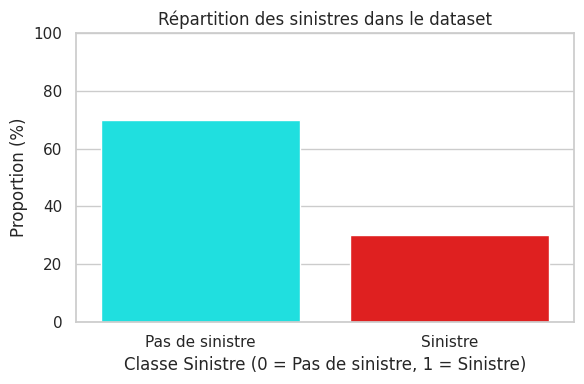

## Analyse de la variable numérique : Exposure



,Exposure
count,892451.000000
mean,0.572492
std,0.362034
min,0.002732
25%,0.230000
50%,0.560000
75%,1.000000
max,1.000000


/tmp/ipykernel_248340/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


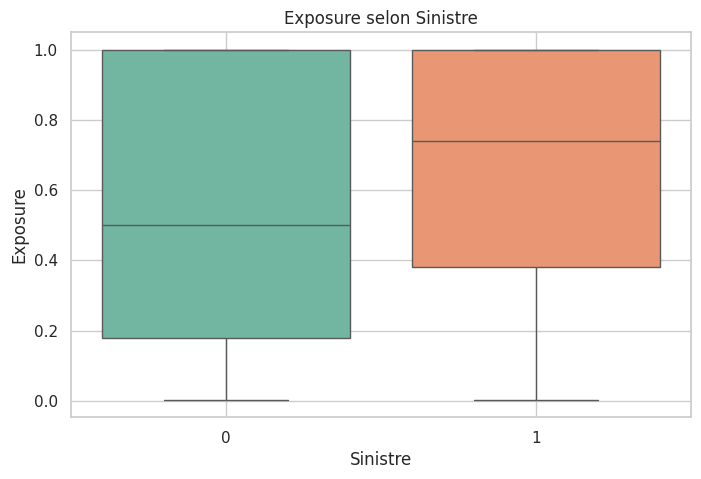

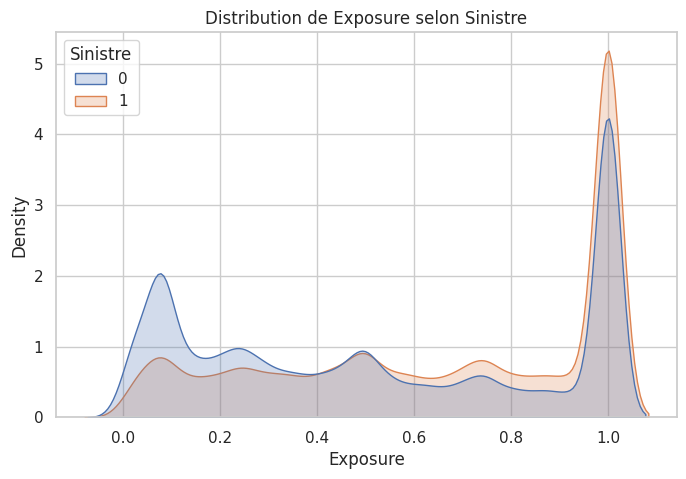


🧪 Test de Kolmogorov-Smirnov sur la variable 'Exposure'
------------------------------------------------------------
📈 Statistique KS : 0.1630
📊 Valeur p       : 0.0000e+00
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : 🟢 Faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.50
📈 Médiane (classe 1) : 0.74
➡️  Différence absolue de médiane : 0.24

## Analyse de la variable numérique : Power



,Power
count,892451.000000
mean,0.116908
std,0.151295
min,0.000000
25%,0.017241
50%,0.025862
75%,0.224138
max,1.000000


/tmp/ipykernel_248340/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


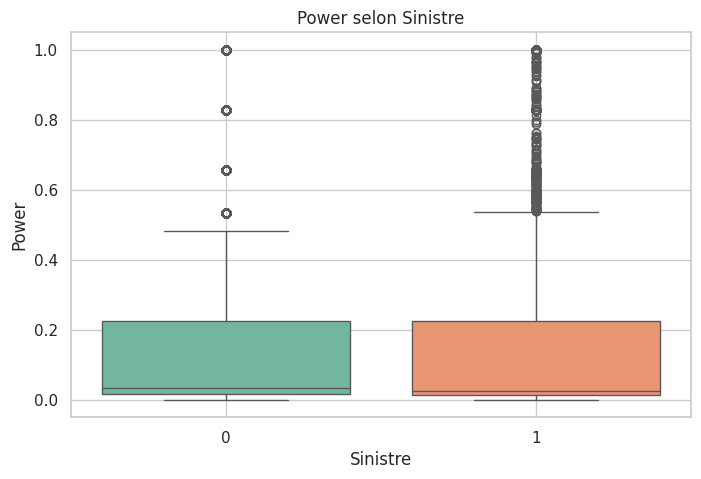

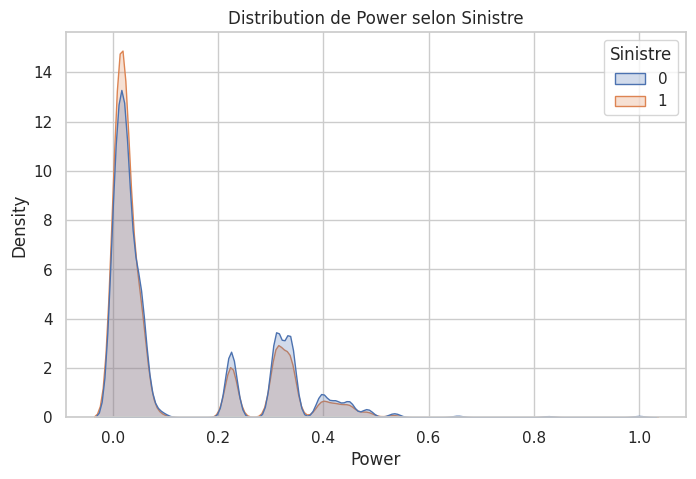


🧪 Test de Kolmogorov-Smirnov sur la variable 'Power'
------------------------------------------------------------
📈 Statistique KS : 0.0835
📊 Valeur p       : 0.0000e+00
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.03
📈 Médiane (classe 1) : 0.03
➡️  Différence absolue de médiane : 0.01

## Analyse de la variable numérique : DriverAge



,DriverAge
count,892451.000000
mean,0.335682
std,0.175353
min,0.000000
25%,0.195122
50%,0.327242
75%,0.451220
max,1.000000


/tmp/ipykernel_248340/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


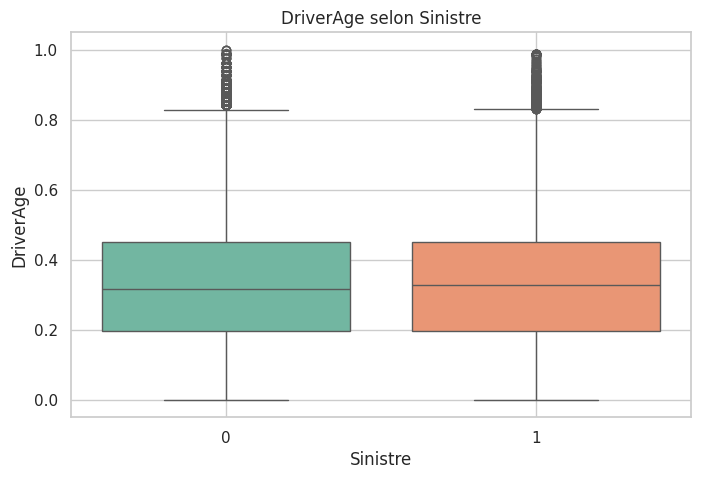

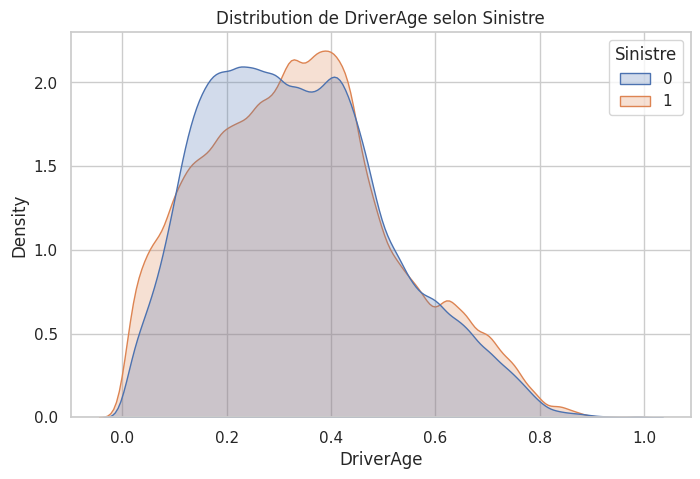


🧪 Test de Kolmogorov-Smirnov sur la variable 'DriverAge'
------------------------------------------------------------
📈 Statistique KS : 0.0318
📊 Valeur p       : 5.4912e-165
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.32
📈 Médiane (classe 1) : 0.33
➡️  Différence absolue de médiane : 0.01

## Analyse de la variable numérique : Density



,Density
count,892451.000000
mean,0.069785
std,0.159811
min,0.000000
25%,0.003148
50%,0.013223
75%,0.059224
max,1.000000


/tmp/ipykernel_248340/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


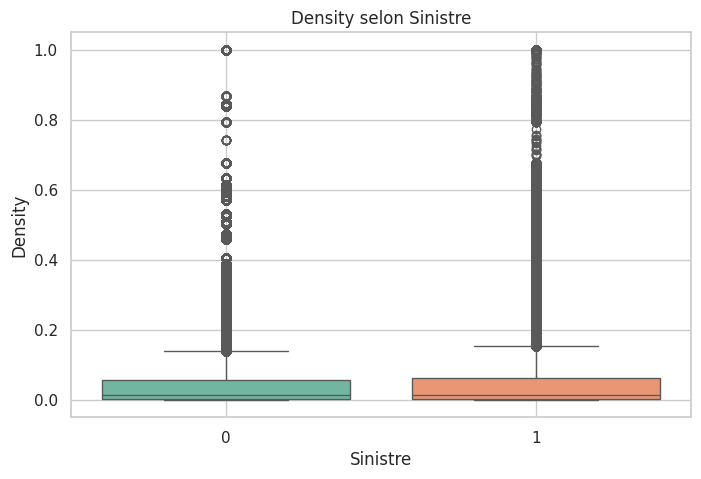

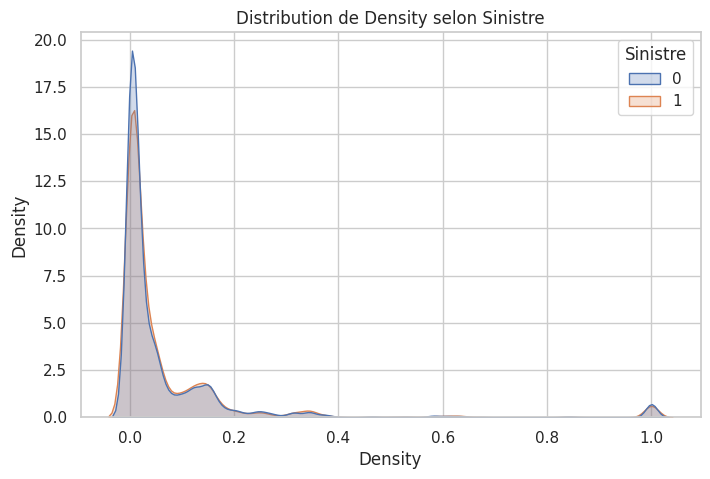


🧪 Test de Kolmogorov-Smirnov sur la variable 'Density'
------------------------------------------------------------
📈 Statistique KS : 0.0402
📊 Valeur p       : 1.8245e-264
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.01
📈 Médiane (classe 1) : 0.01
➡️  Différence absolue de médiane : 0.00

## Analyse de la variable catégorielle : Fuel_type



,Fuel_type,Effectif,Nombre_sinistres,Taux_de_sinistre
0,0.000000,456729,140447,30.75%
1,1.000000,435722,127912,29.36%


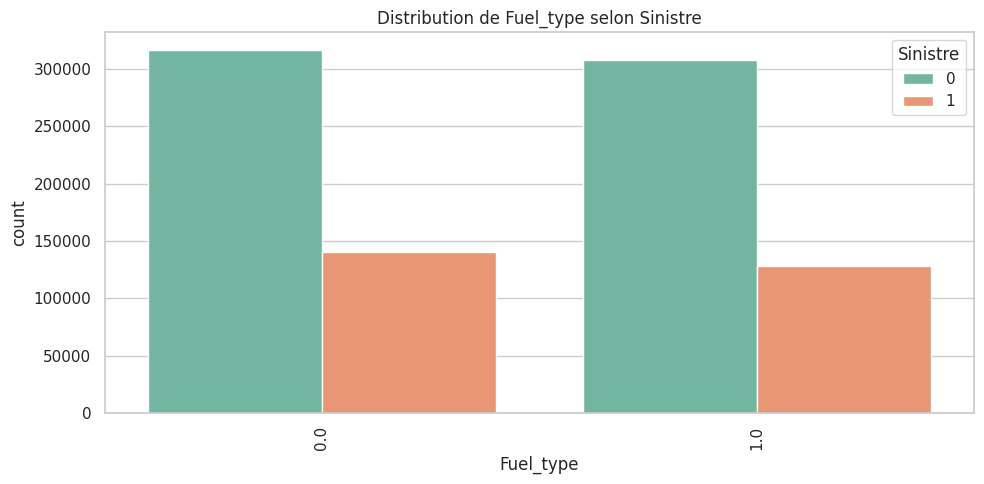

## Analyse de la variable catégorielle : Sex



,Sex,Effectif,Nombre_sinistres,Taux_de_sinistre
0,1.000000,489600,177598,36.27%
1,0.000000,402851,90761,22.53%


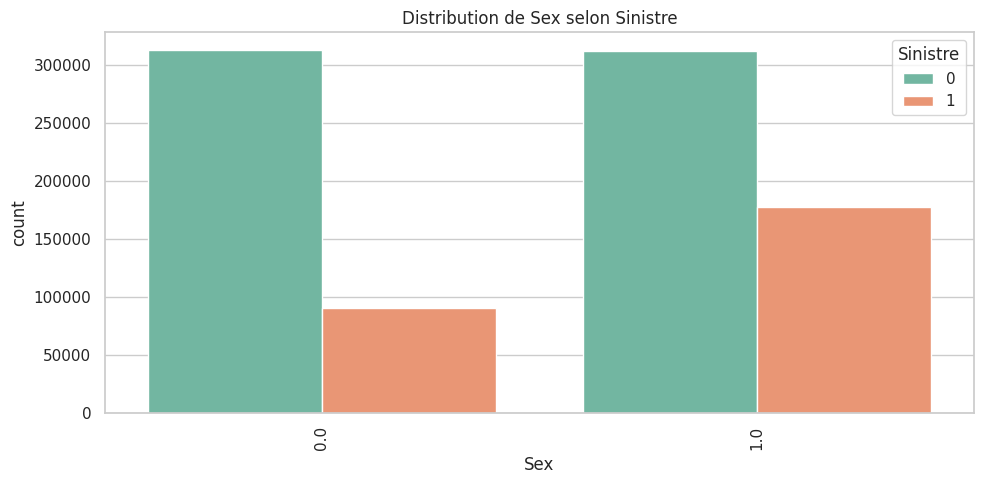

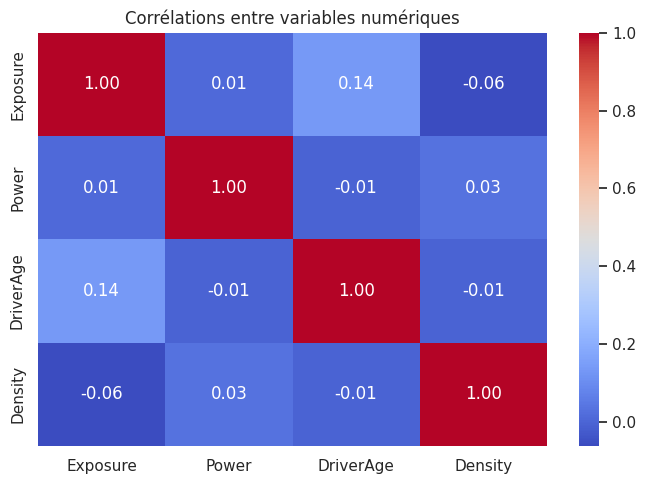

/tmp/ipykernel_248340/2745208832.py:50: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_pvalue, subset=['p-value']) \
/tmp/ipykernel_248340/2745208832.py:51: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'background-color: limegreen' if x else 'background-color: lightcoral',
/tmp/ipykernel_248340/2745208832.py:53: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_strength, subset=['Force de la corrélation']) \


,Paire de variables,Cramer's V,Force de la corrélation,p-value,Significatif
0,Fuel_type - Sinistre,0.015,Faible,0.0000,True
1,Fuel_type - Sex,0.005,Faible,0.0000,True
2,Sinistre - Sex,0.149,Modérée,0.0000,True


In [18]:
# Liste des variables
vars_num = ['Exposure', 'Power', 'DriverAge', 'Density']
vars_cat = ['Fuel_type', 'Sex']


afficher_repartition_sinistres(df_aug_eu,'europe')
# Analyse automatique
for var in vars_num:
    analyse_variable_numerique(df_aug_eu, var,'europe')

for var in vars_cat:
    analyse_variable_categorielle(df_aug_eu, var,'europe')

#Corrélation 
afficher_correlation(df_aug_eu, vars_num,'europe')
results = analyze_categorical_correlation(df_aug_eu)

# Base belge

/tmp/ipykernel_248340/797443313.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=palette)


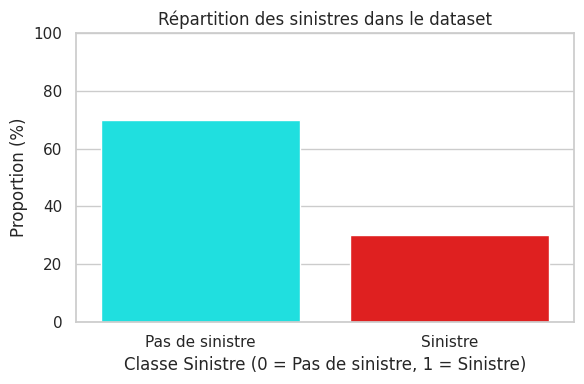

## Analyse de la variable numérique : Exposure



,Exposure
count,124354.00000
mean,0.89788
std,0.23274
min,0.00274
25%,1.00000
50%,1.00000
75%,1.00000
max,1.00000


/tmp/ipykernel_248340/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


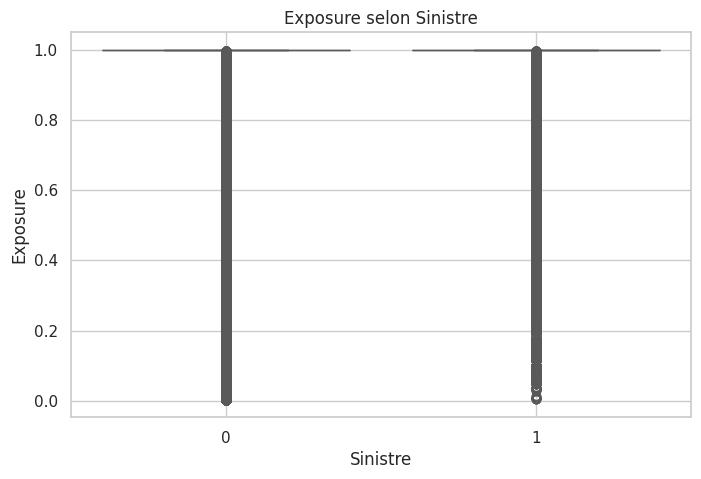

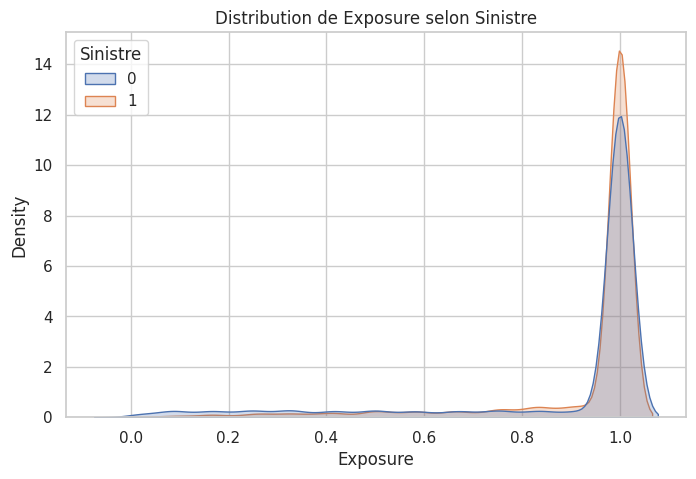


🧪 Test de Kolmogorov-Smirnov sur la variable 'Exposure'
------------------------------------------------------------
📈 Statistique KS : 0.0626
📊 Valeur p       : 2.0703e-89
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 1.00
📈 Médiane (classe 1) : 1.00
➡️  Différence absolue de médiane : 0.00

## Analyse de la variable numérique : Power



,Power
count,124354.000000
mean,0.197966
std,0.082100
min,0.000000
25%,0.141631
50%,0.184549
75%,0.240343
max,1.000000


/tmp/ipykernel_248340/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


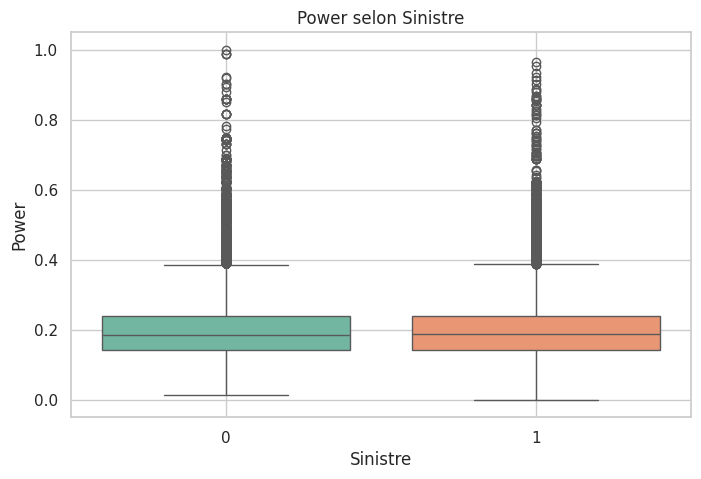

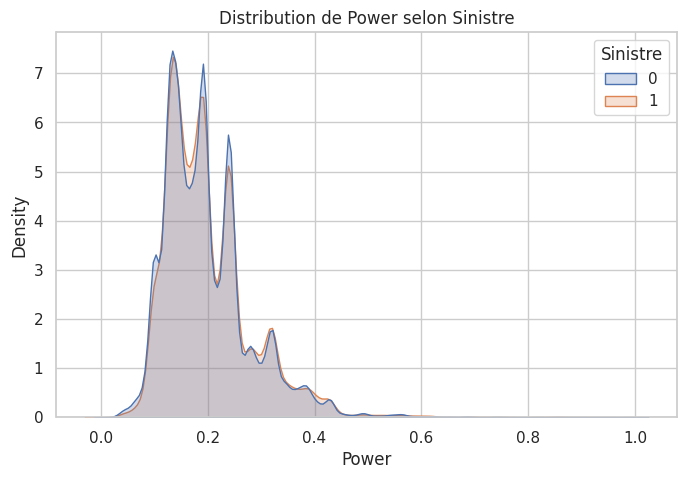


🧪 Test de Kolmogorov-Smirnov sur la variable 'Power'
------------------------------------------------------------
📈 Statistique KS : 0.0332
📊 Valeur p       : 1.8604e-25
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.18
📈 Médiane (classe 1) : 0.19
➡️  Différence absolue de médiane : 0.00

## Analyse de la variable numérique : DriverAge



,DriverAge
count,124354.000000
mean,0.368932
std,0.192857
min,0.000000
25%,0.207792
50%,0.350649
75%,0.506494
max,1.000000


/tmp/ipykernel_248340/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


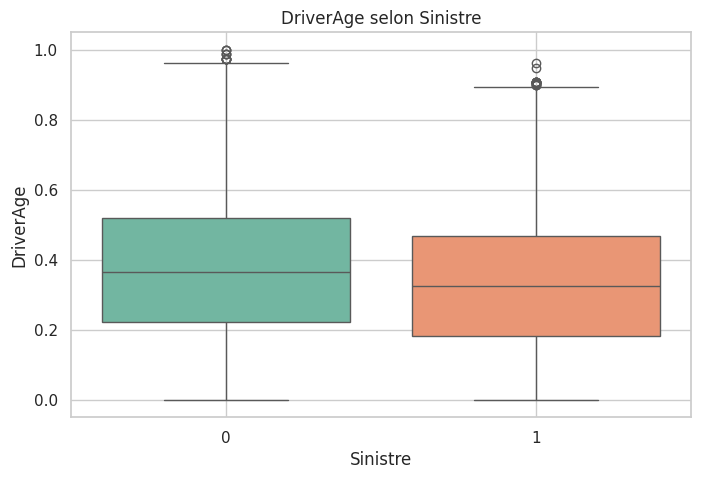

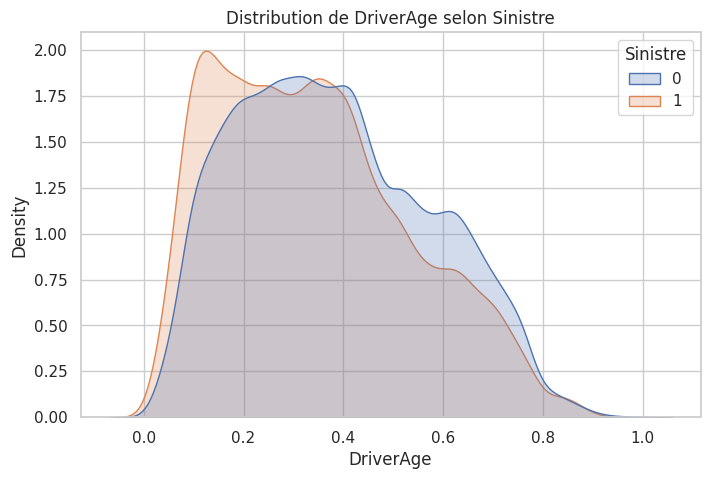


🧪 Test de Kolmogorov-Smirnov sur la variable 'DriverAge'
------------------------------------------------------------
📈 Statistique KS : 0.0872
📊 Valeur p       : 2.8553e-173
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.36
📈 Médiane (classe 1) : 0.32
➡️  Différence absolue de médiane : 0.04

## Analyse de la variable numérique : Density



,Density
count,124354.000000
mean,0.063069
std,0.142517
min,0.000000
25%,0.009544
50%,0.021939
75%,0.043230
max,1.000000


/tmp/ipykernel_248340/2819472562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


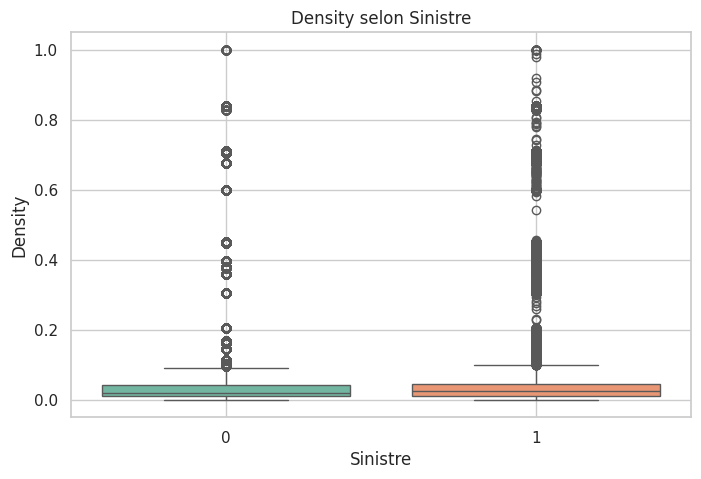

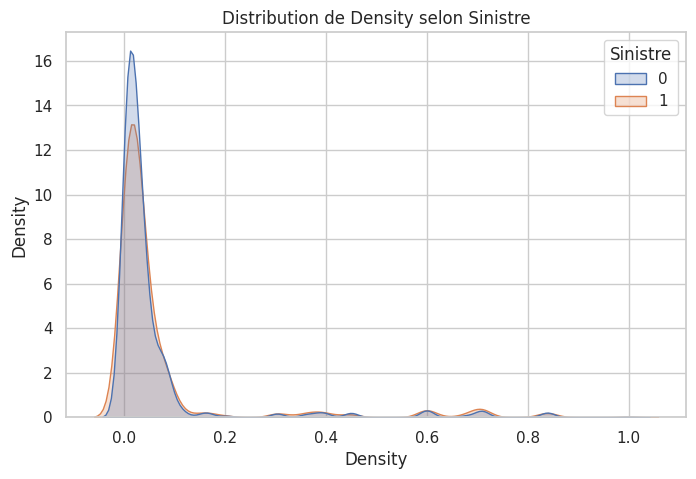


🧪 Test de Kolmogorov-Smirnov sur la variable 'Density'
------------------------------------------------------------
📈 Statistique KS : 0.0418
📊 Valeur p       : 4.0463e-40
✅ Résultat : Les distributions sont **significativement différentes** (p < 0.05)
📌 Intensité de l'écart : ⚪️ Très faible différence
------------------------------------------------------------
📉 Médiane (classe 0) : 0.02
📈 Médiane (classe 1) : 0.02
➡️  Différence absolue de médiane : 0.00

## Analyse de la variable catégorielle : Fuel_type



,Fuel_type,Effectif,Nombre_sinistres,Taux_de_sinistre
0,1.000000,39258,12868,32.78%
1,0.000000,85096,24525,28.82%


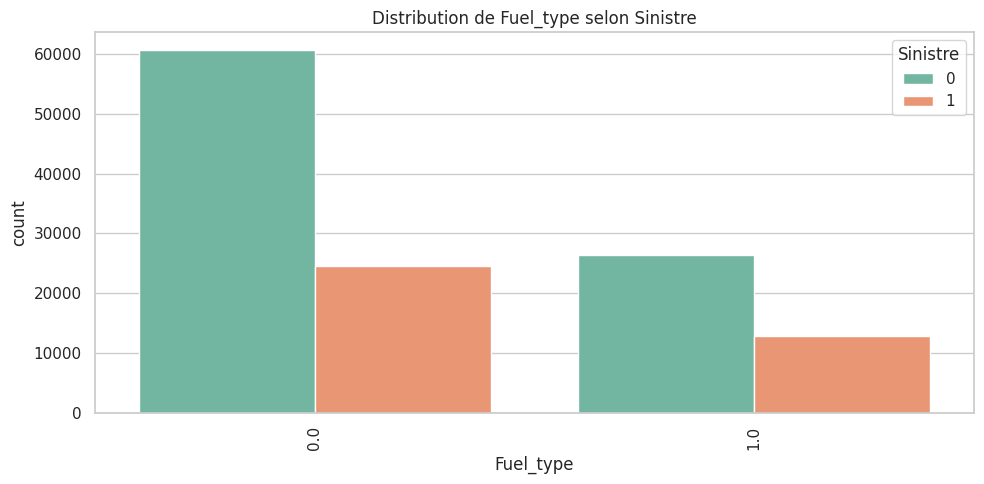

## Analyse de la variable catégorielle : Sex



,Sex,Effectif,Nombre_sinistres,Taux_de_sinistre
0,0.000000,33227,10350,31.15%
1,1.000000,91127,27043,29.68%


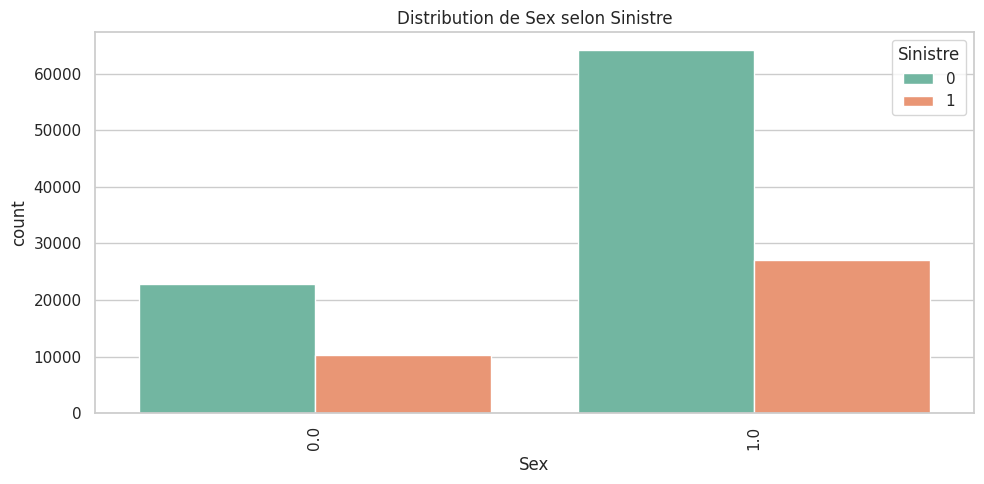

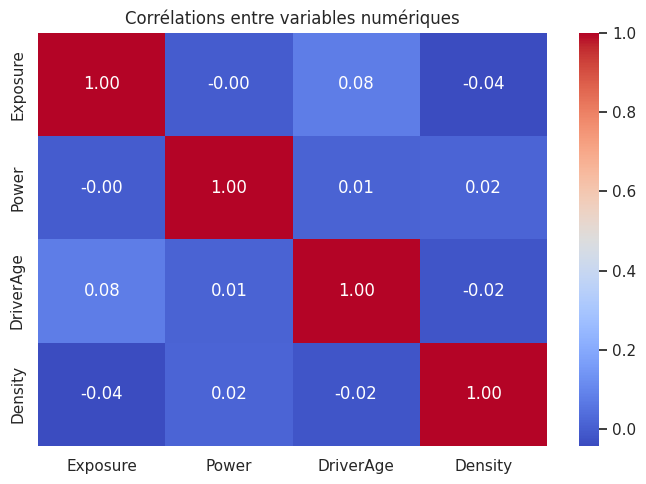

/tmp/ipykernel_248340/2745208832.py:50: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_pvalue, subset=['p-value']) \
/tmp/ipykernel_248340/2745208832.py:51: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'background-color: limegreen' if x else 'background-color: lightcoral',
/tmp/ipykernel_248340/2745208832.py:53: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_strength, subset=['Force de la corrélation']) \


,Paire de variables,Cramer's V,Force de la corrélation,p-value,Significatif
0,Fuel_type - Sinistre,0.040,Faible,0.0000,True
1,Fuel_type - Sex,0.108,Modérée,0.0000,True
2,Sinistre - Sex,0.014,Faible,0.0000,True


In [19]:
# Liste des variables
vars_num = ['Exposure', 'Power', 'DriverAge', 'Density']
vars_cat = ['Fuel_type', 'Sex']


afficher_repartition_sinistres(df_aug_be,'belge')
# Analyse automatique
for var in vars_num:
    analyse_variable_numerique(df_aug_be, var,'belge')

for var in vars_cat:
    analyse_variable_categorielle(df_aug_be, var,'belge')

#Corrélation 
afficher_correlation(df_aug_be, vars_num,'belge')
results = analyze_categorical_correlation(df_aug_be)

# ALL

In [20]:
def plot_kde_by_country(df, country_col='Country', var = 'Sinistre'):
    # Variables à exclure car ce sont des catégorielles même si elles sont numériques
    categorical_numerics = ['Sinistre', 'Sex', 'Fuel_type']

    # Sélection des variables numériques sans les variables catégorielles ni le pays
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in categorical_numerics + [country_col]]

    # Boucle sur chaque variable numérique "continue"
    for col in numeric_cols:
        plt.figure(figsize=(10, 6))
        sns.kdeplot(data=df, x=col, hue=country_col, fill=True, common_norm=False, alpha=0.5)
        plt.title(f'Distribution de {col} par pays')
        plt.xlabel(col)
        plt.ylabel('Densité')
        plt.tight_layout()
        plt.savefig(f"images/kde_all_{col}_{var}_.png")
        plt.show()


def plot_boxplots_by_country(df, country_col='Country', var = 'Sinistre'):
    # Variables à exclure car ce sont des catégorielles même si elles sont numériques
    categorical_numerics = ['Sinistre', 'Sex', 'Fuel_type']

    # Sélection des variables numériques sans les variables catégorielles ni le pays
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in categorical_numerics + [country_col]]

    # Boucle sur chaque variable numérique
    for col in numeric_cols:
        plt.figure(figsize=(10, 6))
        sns.boxplot(
            data=df,
            x=country_col,
            y=col,
            palette='pastel',
            showfliers=False  # Cache les outliers pour rendre plus lisible (optionnel)
        )  # Couleurs différentes
        plt.title(f'Repartition de {col} par pays')
        plt.xlabel('Pays')
        plt.ylabel(col)
        plt.tight_layout()
        plt.savefig(f"images/boxplot_all_{col}_{var}_.png")
        plt.show()


def plot_multiple_proportions(data, group_col, target_cols, palette='Set2', var = 'Sinistre'):
    for target_col in target_cols:
        # Comptage brut
        count_df = data.groupby([group_col, target_col]).size().reset_index(name='Count')
        
        # Total des lignes par group_col (ex: par pays)
        total_df = data.groupby(group_col).size().reset_index(name='Total')
        
        # Fusion des deux tableaux
        merged_df = pd.merge(count_df, total_df, on=group_col)
        merged_df['Proportion'] = merged_df['Count'] / merged_df['Total']
        
        # Affichage
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(data=merged_df, x=group_col, y='Proportion', hue=target_col, palette=palette)

        # Ajout des étiquettes
        for container in ax.containers:
            ax.bar_label(container, labels=[f'{100 * h:.2f}%' for h in container.datavalues], label_type='edge')

        plt.ylim(0, 1)
        plt.title(f"Distribution de {target_col} par {group_col}", fontsize=16, weight='bold')
        plt.ylabel("Proportion (%)")
        plt.xlabel(group_col)
        plt.legend(title=target_col, loc='best')
        plt.tight_layout()
        plt.savefig(f"images/proportion_all_{target_col}_{var}_.png")
        plt.show()

# Liste des variables catégorielles à analyser
cat_vars = ['Sinistre', 'Sex', 'Fuel_type']

# Appel de la fonction


In [21]:
data_sin = data_aug[data_aug['Sinistre'] == 1]

In [22]:
data_nsin = data_aug[data_aug['Sinistre'] == 0]

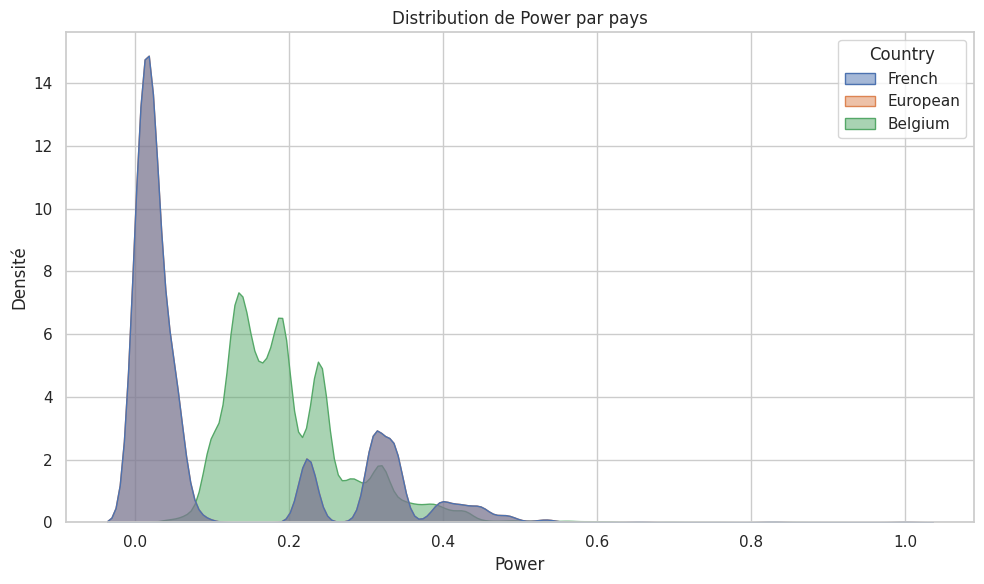

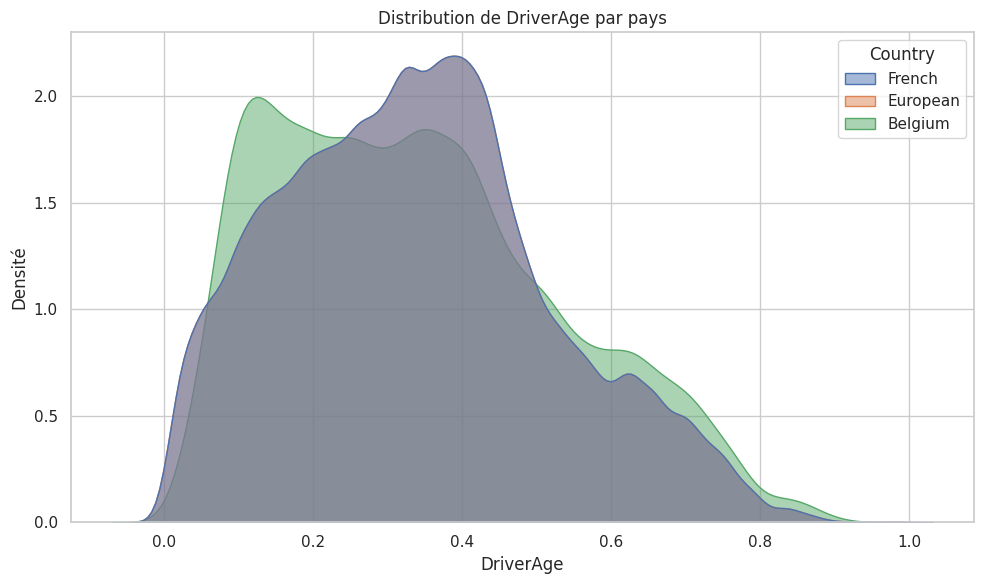

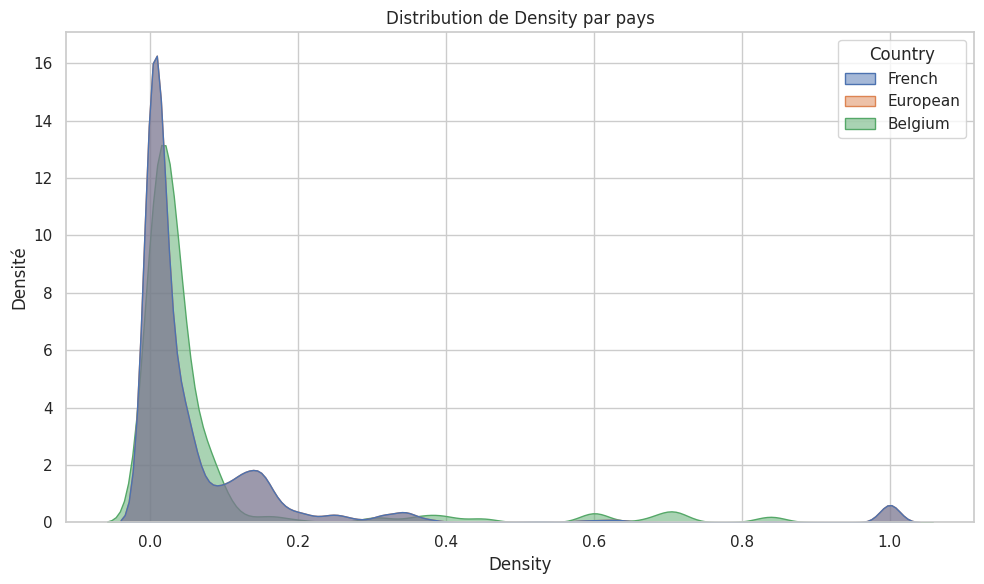

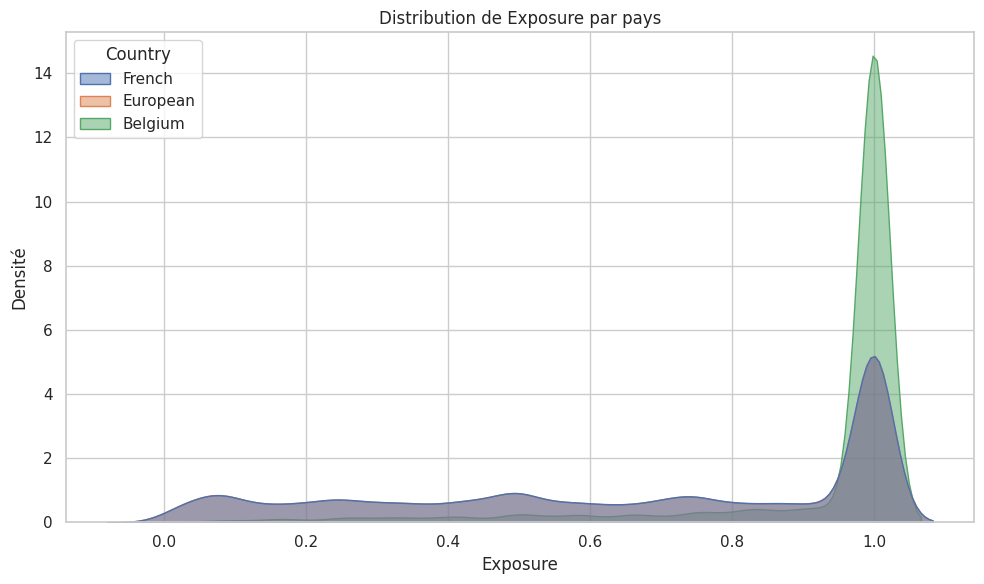

In [23]:
plot_kde_by_country(data_sin)

/tmp/ipykernel_248340/823348990.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


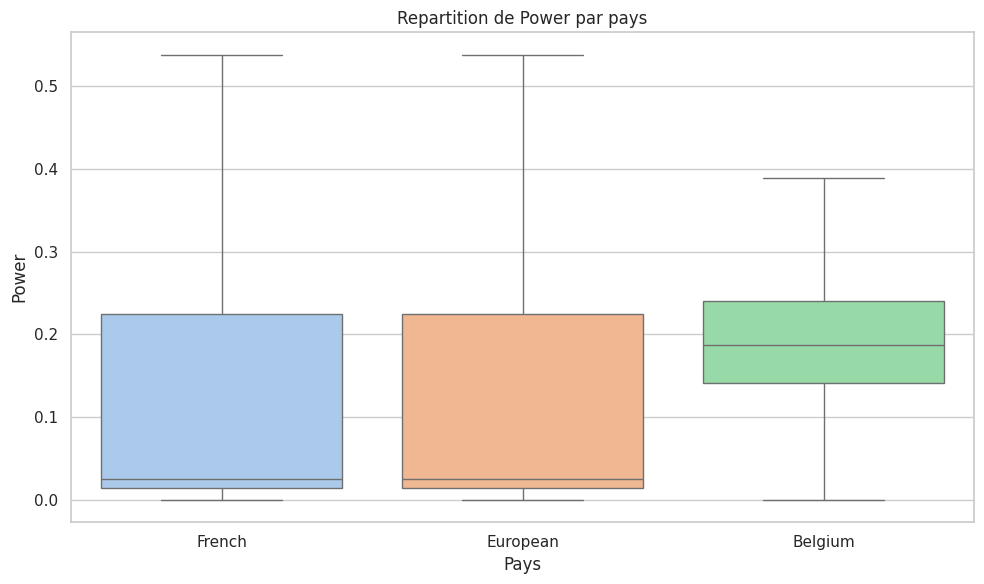

/tmp/ipykernel_248340/823348990.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


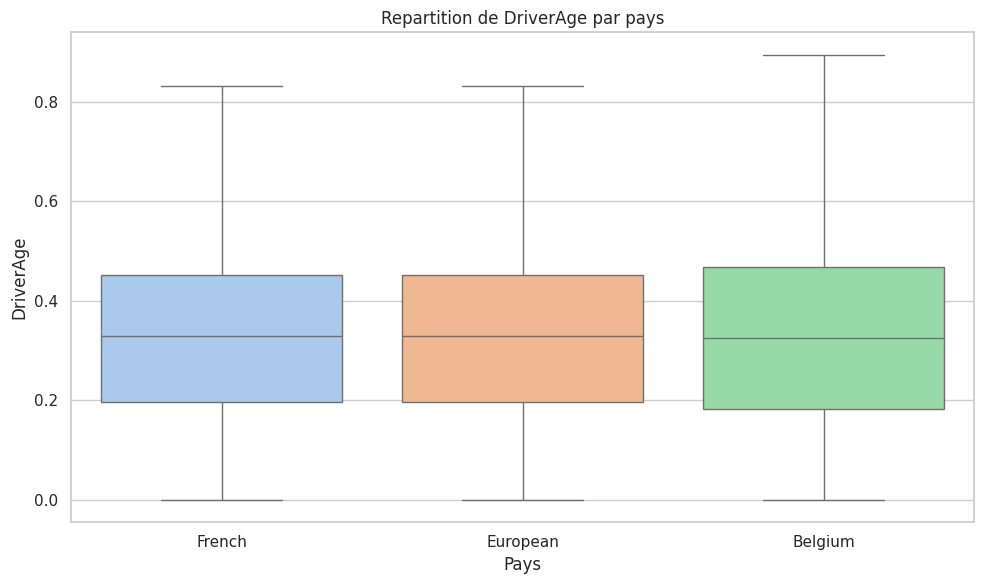

/tmp/ipykernel_248340/823348990.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


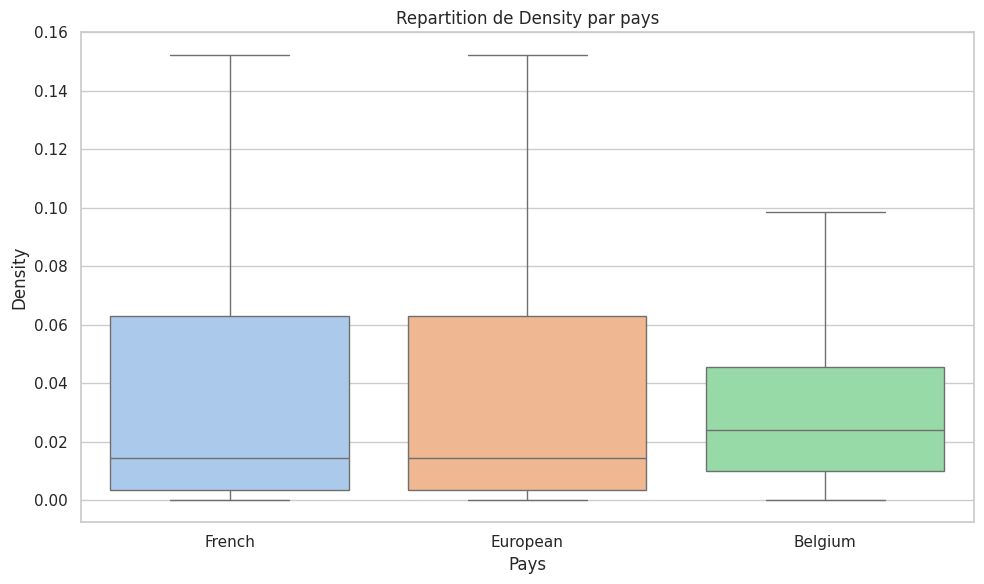

/tmp/ipykernel_248340/823348990.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


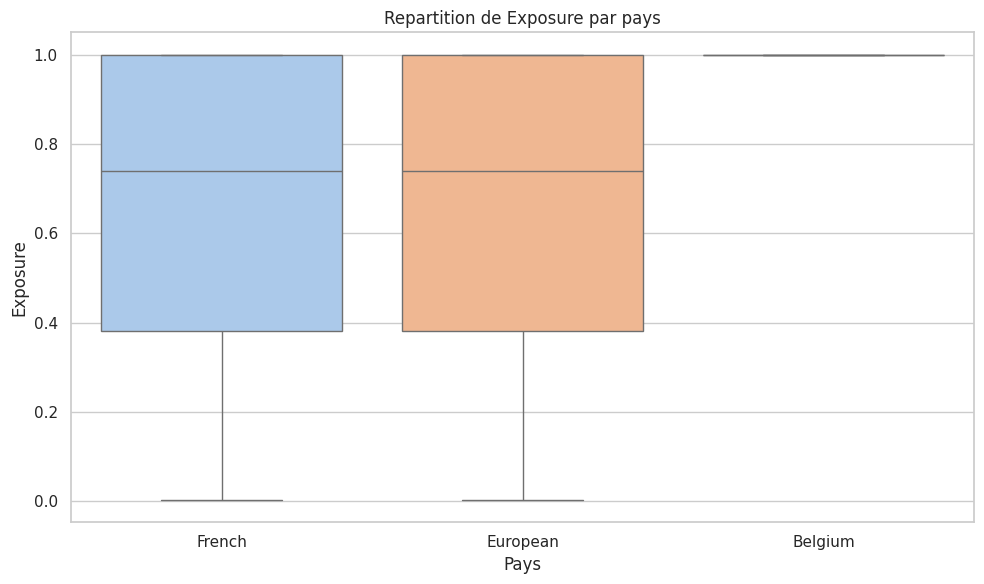

In [24]:
plot_boxplots_by_country(data_sin)

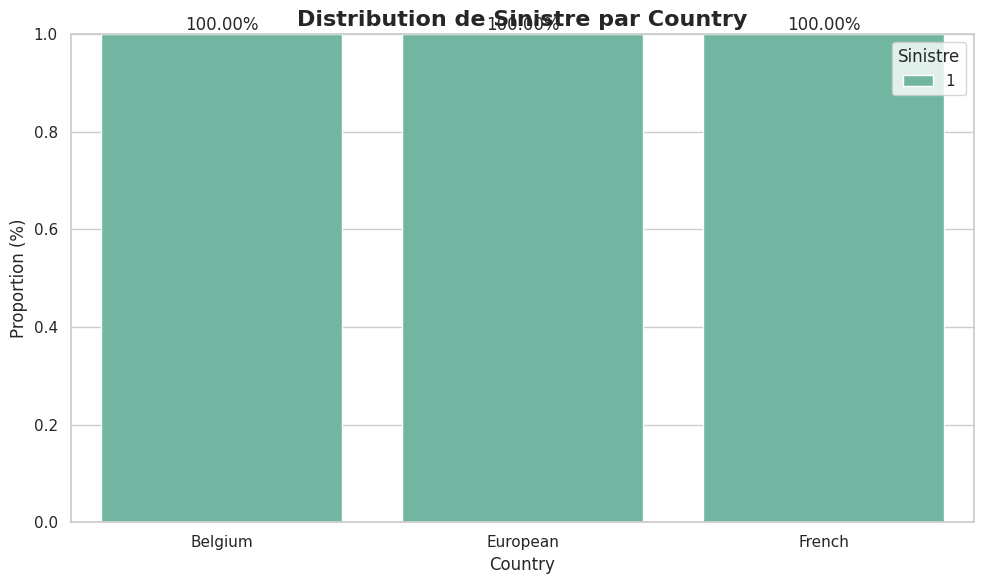

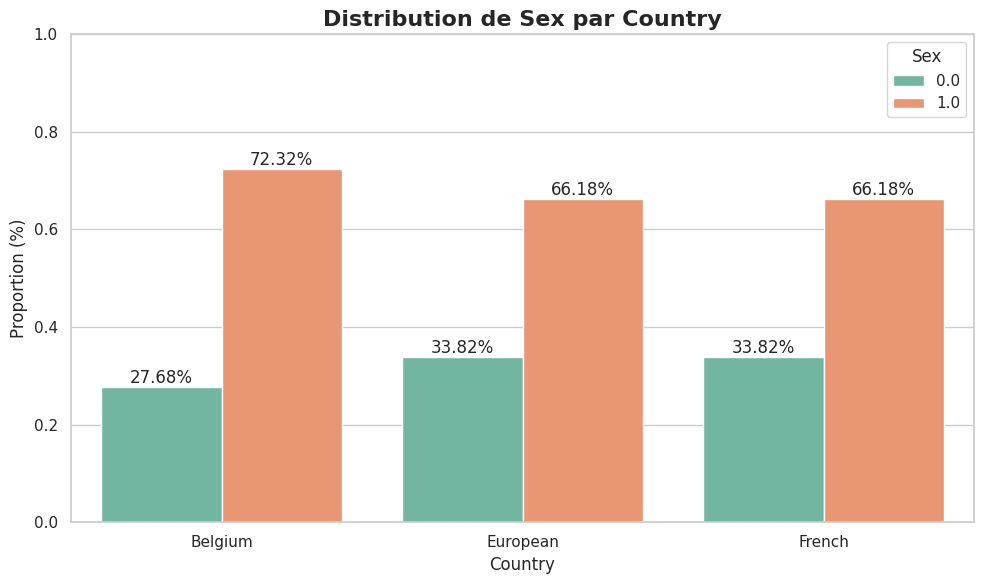

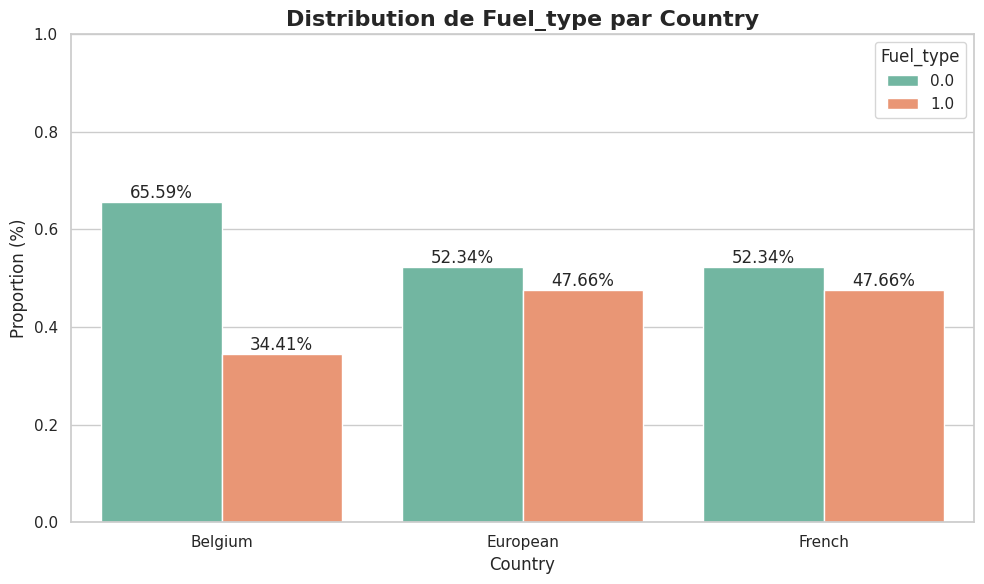

In [25]:
plot_multiple_proportions(data_sin, group_col='Country', target_cols=cat_vars)

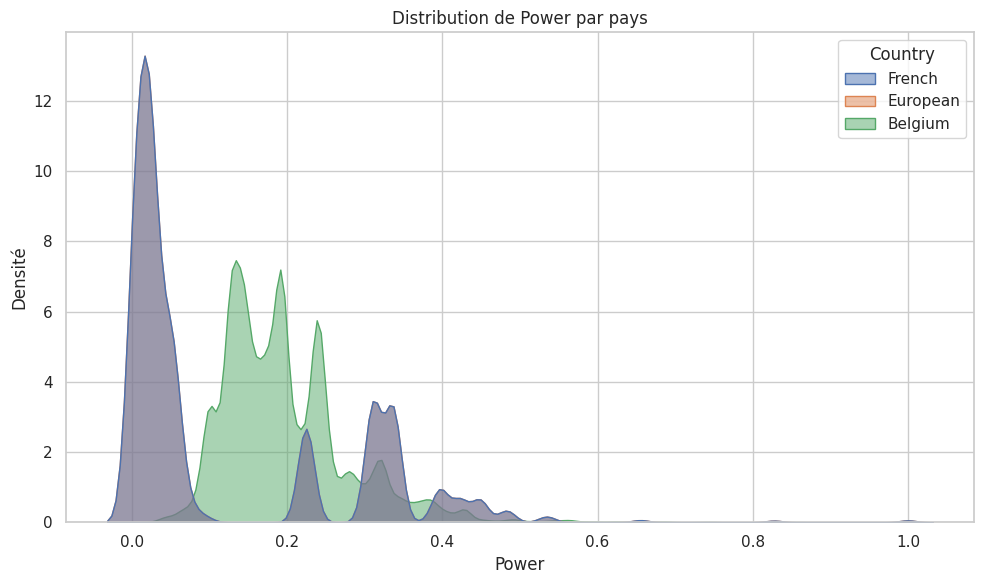

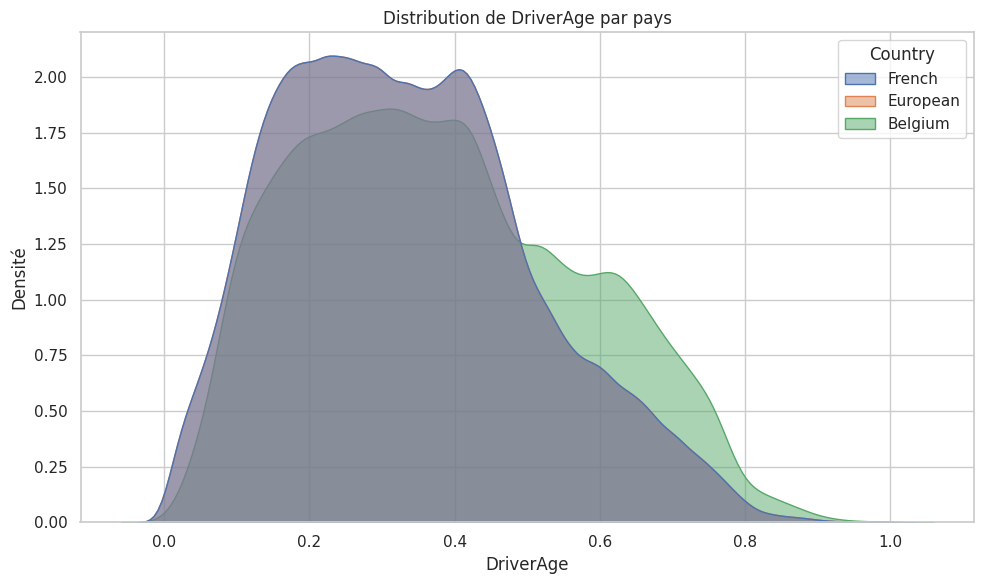

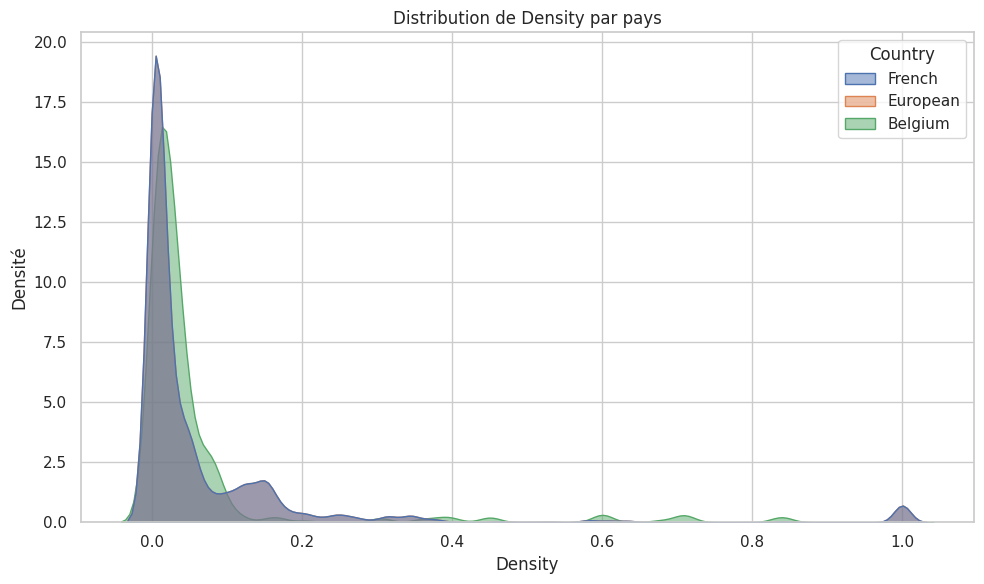

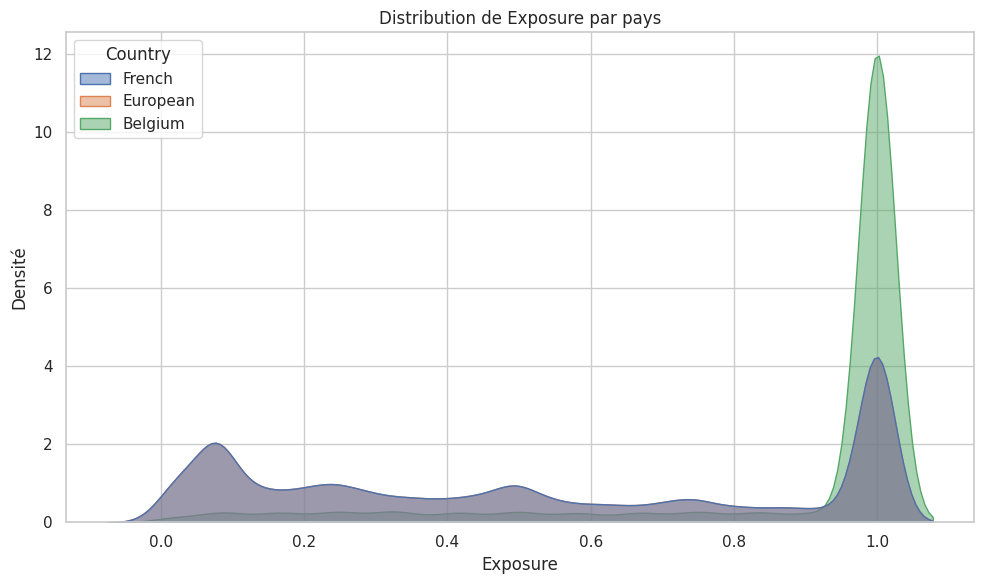

In [26]:
plot_kde_by_country(data_nsin, var='Non_Sinistre')

/tmp/ipykernel_248340/823348990.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


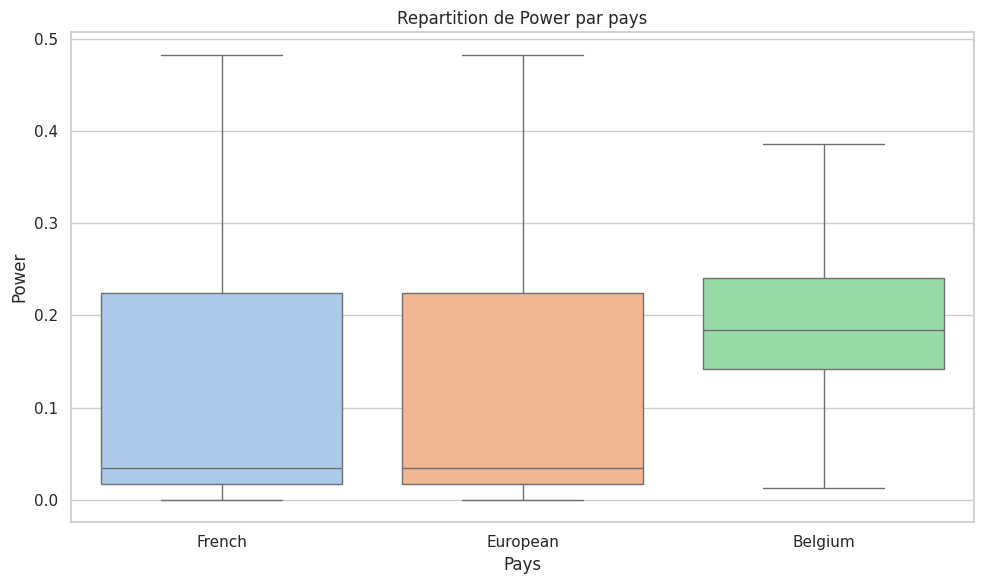

/tmp/ipykernel_248340/823348990.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


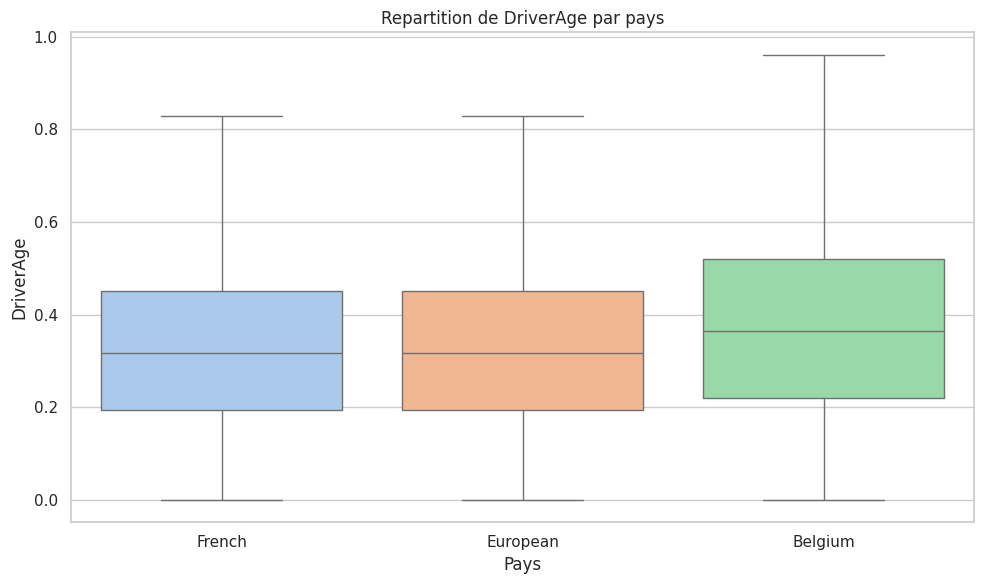

/tmp/ipykernel_248340/823348990.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


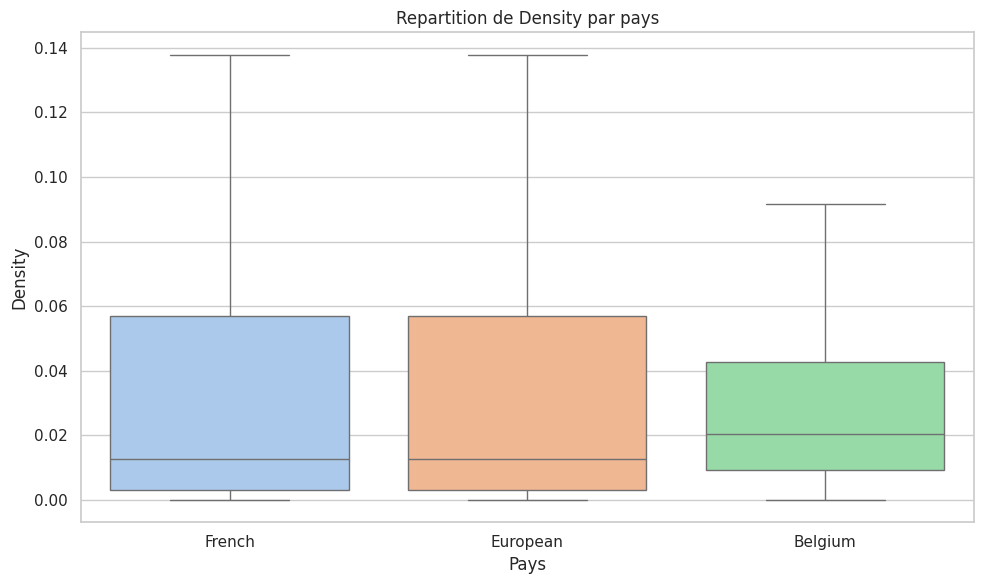

/tmp/ipykernel_248340/823348990.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


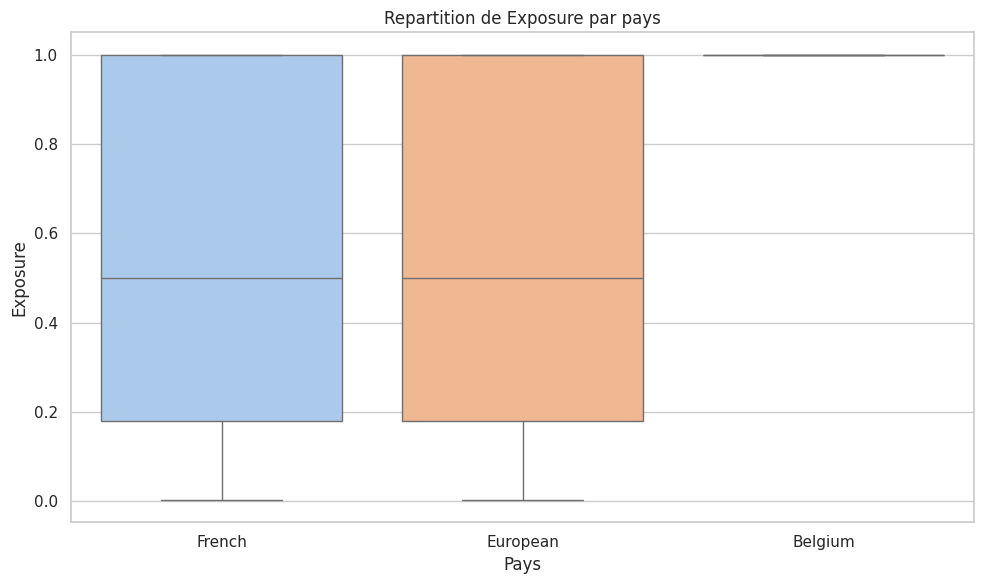

In [27]:
plot_boxplots_by_country(data_nsin, var='Non_Sinistre')

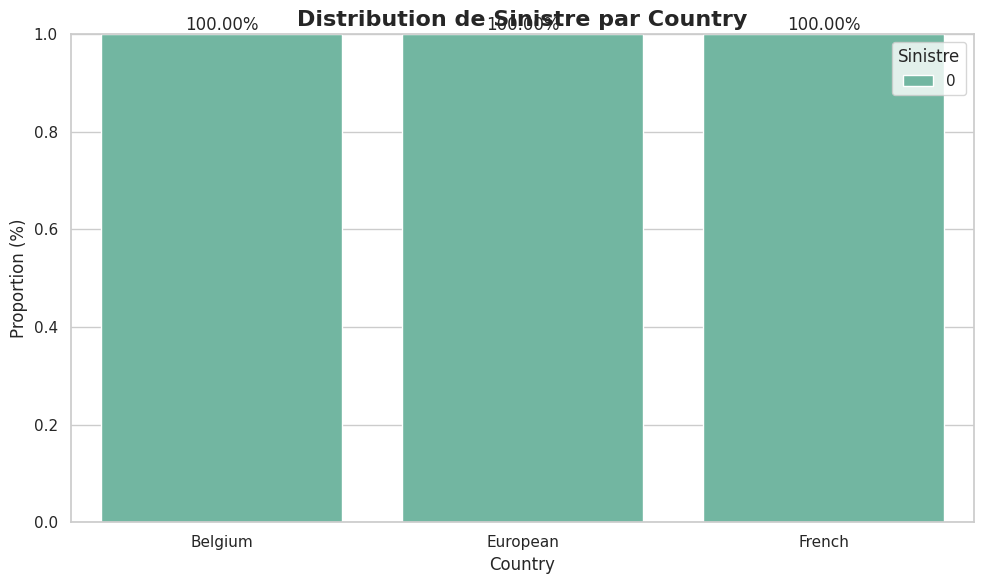

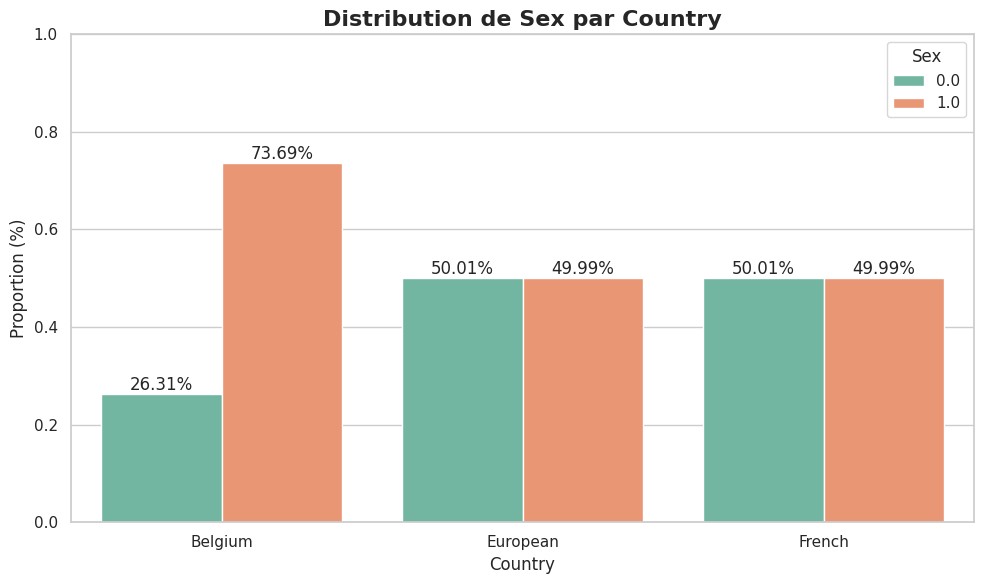

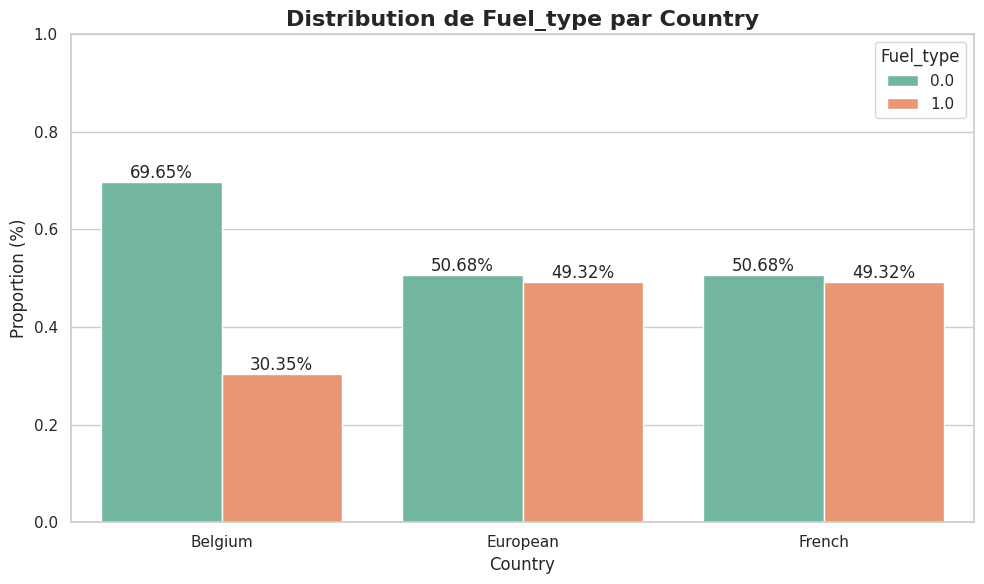

In [28]:
plot_multiple_proportions(data_nsin, var='Non_Sinistre', group_col='Country', target_cols=cat_vars)